In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys
import os
import json
import matplotlib.lines     as mlines
import tqdm
from scipy.stats    import gmean
import torch
from torch.autograd.functional import jacobian
from time import time
from natsort                import natsorted
from matplotlib.ticker import FixedLocator


from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
rc('font', family='serif')
rc('text', usetex=True)
# plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')

import src.mace.CSE_0D.dataset          as ds
import src.mace.CSE_0D.intregr_train    as tr
import src.mace.neuralODE               as nODE
from src.mace.CSE_0D.loss               import Loss
import src.mace.CSE_0D.loss             as loss
import src.mace.CSE_0D.plotting         as pl
import src.mace.utils                   as utils
# from src.mace.neuralODE    import Solver

def temp(Tstar, eps, r):
    Rstar = 2e13
    # r = 1e16
    T = Tstar * (r/Rstar)**(-eps)
    return T

specs_dict, idx_specs = utils.get_specs()

%reload_ext autoreload
%autoreload 2

### Testing input file mace_training_routine

In [84]:
inFile = '/STER/silkem/MACE/input/input_test.txt'
with open(inFile,'r') as f:
    file = f.readlines()
    lines = []
    for line in file:
        lines.append(line.split())

inputfile = {}
for i in range(len(lines)):
    if not len(lines[i]) == 0 and len(lines[i]) > 2:
        # print(test[i])
        inputfile[lines[i][0]] = lines[i][2]
    elif not len(lines[i]) == 0 and len(lines[i]) <= 2:
        print('You forgot to give an input for '+lines[i][0])

## SET PARAMETERS
lr          = float(inputfile['lr'])
tot_epochs  = int(inputfile['tot_epochs'])
nb_epochs   = int(inputfile['nb_epochs'])
ini_epochs  = 5
losstype    = inputfile['losstype']
z_dim       = int(inputfile['z_dim'])
batch_size  = 1
nb_samples  = int(inputfile['nb_samples'])
n_dim       = 468

### Retrieving the min & max values of the dataset

In [79]:
## density
rho_min = np.inf
rho_max = 0
## temperature
T_max = 0
## delta
delta_min = np.inf
delta_max = 0
## Av
Av_min = np.inf
Av_max = 0

dt_max = 0


lens = dict()

for i, path in enumerate(inputdirs):
    print(i, end='\r')

    mod = ds.CSEmod(path)

    ## check the length of the model
    if len(mod) != 135:
        lens[i] = len(mod)
    
    ## check the min and max of the parameters
    ## density
    rho_min_mod = min(mod.get_dens())
    rho_max_mod = max(mod.get_dens())
    if rho_min_mod < rho_min:
        rho_min = rho_min_mod
    if rho_max_mod > rho_max:
        rho_max = rho_max_mod
    ## Av
    Av_min_mod = min(mod.get_Av())
    Av_max_mod = max(mod.get_Av())
    if Av_min_mod < Av_min:
        Av_min = Av_min_mod
    if Av_max_mod > Av_max:
        Av_max = Av_max_mod
    ## temperature
    T_max_mod = max(mod.get_temp())
    if T_max_mod > T_max:
        T_max = T_max_mod
    ## delta
    delta_min_mod = min(mod.get_delta())
    delta_max_mod = max(mod.get_delta())
    if delta_min_mod < delta_min:
        delta_min = delta_min_mod
    if delta_max_mod > delta_max:
        delta_max = delta_max_mod

    ## dt
    dt_max_mod = max(mod.get_dt())
    if dt_max_mod > dt_max:
        dt_max = dt_max_mod

    


In [80]:
## density
print('dens:',rho_min, rho_max)
## temperature
print('temp: 10',T_max)
## delta
print('delta',delta_min, delta_max)
## Av
print('Av',Av_min, Av_max)

print('dt',dt_max)

dens: 0.008223 5009000000.0
temp: 10 1851.0
delta 0.0 0.9999
Av 2.141e-05 1246.0
dt 434800000000.0


In [83]:
meta = {'dens_min': rho_min,
        'dens_max': rho_max,
        'temp_min': 10.,
        'temp_max': T_max,
        'delta_min': delta_min,
        'delta_max': delta_max,
        'Av_min': Av_min,
        'Av_max': Av_max,
        'dt_max': dt_max
        }


json_object = json.dumps(meta, indent=4)
with open("/STER/silkem/MACE/data/minmax.json", "w") as outfile:
    outfile.write(json_object)

### Testing the dataset class

In [3]:
inputdirs = np.loadtxt('data/paths_data_C.txt', dtype=str)

In [4]:
len(inputdirs)

18314

In [15]:
inputdirs[-1]

'/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v20_T_eps/models/model_2023-01-10h12-19-34/csfrac_smooth.out'

In [13]:
for i, path in enumerate(inputdirs):
    print(i, path, end='\r')
    # try:
    mod = ds.CSEmod(path)
    # except Exception as e:
    #     print(e)
    #     print("does not exist",i, path)


In [73]:
mod = ds.CSEmod(inputdirs[18241])
dt,n,p = mod.split_in_0D()

In [41]:
dt.shape, n.shape, p.shape

((80,), (81, 468), (80, 4))

In [42]:
n = n.reshape(81,468)
n.shape

(81, 468)

In [44]:
n[:-1].shape, n[1:].shape

((80, 468), (80, 468))

In [7]:
mod1 = ds.CSEmod(inputdirs[17982])
mod2 = ds.CSEmod(inputdirs[18241])
len(mod1), len(mod2)

(135, 81)

In [90]:
dt1, n1, p1 = mod1.split_in_0D()
dt2, n2, p2 = mod2.split_in_0D()

In [91]:
dt1.shape, n1.shape, p1.shape, dt2.shape, n2.shape, p2.shape


((134,), (134, 468), (134, 4), (80,), (80, 468), (80, 4))

In [93]:
h = np.concatenate((dt1, dt2), axis=0)
h.shape

(214,)

In [33]:
def generate_random_numbers(n, start, end):
    return np.random.randint(start, end, size=n)

# Generate 10 random integers between 1 and 100
random_numbers = generate_random_numbers(10, 1, 100)

In [68]:
dt, n, p = mod.split_in_0D()
delta = p[:,2]
# norm_delta = utils.normalise(np.log10(p[:,2]), np.log10(1e-100), np.log10(1e-100+0.999))
# norm_dens = utils.normalise(mod.)
# norm_delta

delta



array([7.226e-84, 1.930e-78, 2.241e-73, 1.196e-68, 3.093e-64, 4.071e-60,
       2.854e-56, 1.113e-52, 2.514e-49, 3.414e-46, 2.887e-43, 1.570e-40,
       5.665e-38, 1.393e-35, 2.396e-33, 2.953e-31, 2.664e-29, 1.795e-27,
       9.210e-26, 3.659e-24, 1.144e-22, 2.860e-21, 5.795e-20, 9.643e-19,
       1.335e-17, 1.555e-16, 1.542e-15, 1.315e-14, 9.743e-14, 6.327e-13,
       3.634e-12, 1.861e-11, 8.565e-11, 3.569e-10, 1.355e-09, 4.723e-09,
       1.519e-08, 4.532e-08, 1.262e-07, 3.294e-07, 8.095e-07, 1.881e-06,
       4.147e-06, 8.708e-06, 1.747e-05, 3.356e-05, 6.195e-05, 1.101e-04,
       1.890e-04, 3.137e-04, 5.047e-04, 7.888e-04, 1.200e-03, 1.778e-03,
       2.573e-03, 3.641e-03, 5.045e-03, 6.855e-03, 9.145e-03, 1.199e-02,
       1.548e-02, 1.968e-02, 2.468e-02, 3.053e-02, 3.732e-02, 4.508e-02,
       5.388e-02, 6.373e-02, 7.465e-02, 8.666e-02, 9.974e-02, 1.139e-01,
       1.290e-01, 1.451e-01, 1.622e-01, 1.800e-01, 1.987e-01, 2.180e-01,
       2.380e-01, 2.585e-01, 2.795e-01, 3.008e-01, 

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out


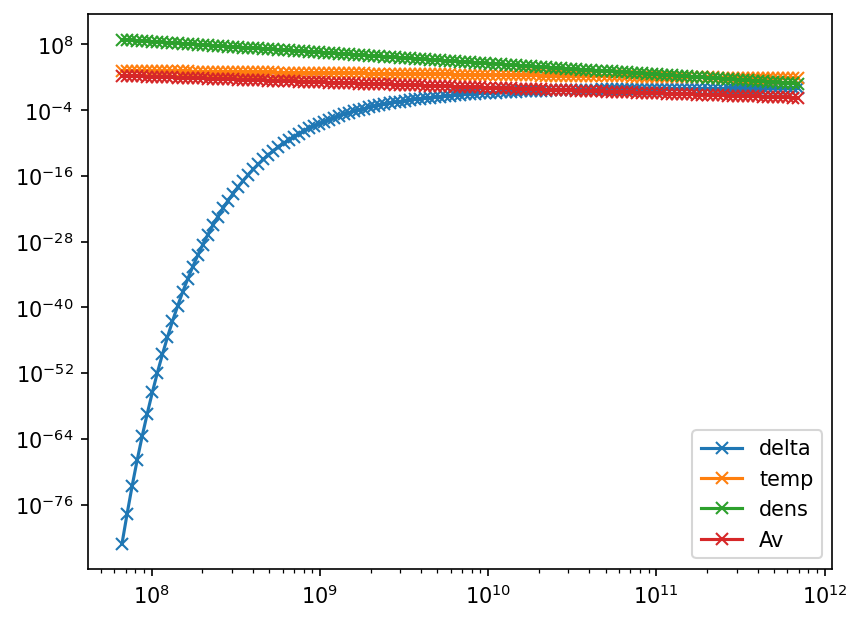

In [116]:
i = 2898-1
mod = ds.CSEmod(inputdirs[i])
print(inputdirs[i])


a=0.5

y = 0.01
# plt.loglog(mod.get_time(), mod.get_delta()+y, '-x', label = 'delta + '+str(y), alpha = a)
y = 1.e-40
# plt.loglog(mod.get_time(), mod.get_delta()+y, '-x', label = 'delta + '+str(y), alpha = a)
plt.loglog(mod.time, mod.get_delta(), '-x', label = 'delta')#, alpha = a)
plt.loglog(mod.get_time(), mod.get_temp(), '-x', label = 'temp')
plt.loglog(mod.get_time(), mod.get_dens(), '-x', label = 'dens')
plt.loglog(mod.get_time(), mod.get_Av(), '-x', label = 'Av')
# plt.loglog(mod.get_time(), mod.get_abs_spec('CO' ),label = 'CO')
# plt.loglog(mod.get_time(), mod.get_abs_spec('H2O'),label = 'H2O')
# plt.loglog(mod.get_time(), mod.get_abs_spec('CH4'),label = 'CH4')
# plt.loglog(mod.get_time(), mod.n[:,-2],label = 'e-')

plt.legend()
plt.show()

### Testing the training

In [2]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 

lr = 1.e-4
epochs = 100

losstype = 'mse_idn'
# losstype = 'mse'
z_dim = 8
dt_fract = 0.2
batch_size = 1
nb_samples = 2
n_dim = 468
nb_hidden = 1
ae_type = 'simple'
nb_test = 3000

print('------------------------------')
print('      # epochs:', epochs)
print(' learning rate:', lr)
print('# z dimensions:', z_dim)
print('     # samples:', nb_samples)
print('     loss type:', losstype)
print('')


train, test, data_loader, test_loader = ds.get_data(dt_fract=dt_fract,nb_samples=nb_samples,nb_test = nb_test, batch_size=batch_size, kwargs=kwargs)

------------------------------
      # epochs: 100
 learning rate: 0.0001
# z dimensions: 8
     # samples: 2
     loss type: mse_idn

Dataset:
------------------------------
  total # of samples: 2
#   training samples: 1
# validation samples: 1
               ratio: 0.5
     #  test samples: 3000


In [8]:
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim,nb_hidden=nb_hidden, ae_type=ae_type, DEVICE = DEVICE)

num_params = utils.count_parameters(model)
print(f'The model has {num_params} trainable parameters\n')


norm = {'mse' : 1,
        'rel' : 1,
        'grd' : 1,
        'idn' : 1}

fract = {'mse' : 1, 
         'rel' : 1,
         'grd' : 1,
         'idn' : 1}


## Make loss objects
trainloss = Loss(norm, fract)
testloss  = Loss(norm, fract)

trainloss.set_losstype(losstype)
testloss.set_losstype(losstype)

tic = time()
opt = tr.train(model, lr, data_loader, test_loader,nb_evol = 44, path = None, end_epochs = epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, start_time = time())
toc = time()

print('\nTraining time [s]:',toc-tic)




The model has 284692 trainable parameters

Model:         
learning rate: 0.0001
loss type:     mse_idn

>>> Training model...




encoder time: 0.011506795883178711
solver  time: 0.015220880508422852
decoder time: 0.001735687255859375

encoder time: 0.0009484291076660156
solver  time: 0.00743556022644043
decoder time: 0.0012879371643066406

encoder time: 0.0010743141174316406
solver  time: 0.006889820098876953
decoder time: 0.0013306140899658203

encoder time: 0.0010099411010742188
solver  time: 0.007465362548828125
decoder time: 0.0014796257019042969

encoder time: 0.0008904933929443359
solver  time: 0.006810903549194336
decoder time: 0.0011990070343017578

encoder time: 0.0009448528289794922
solver  time: 0.007345438003540039
decoder time: 0.0014450550079345703

encoder time: 0.0008912086486816406
solver  time: 0.00729060173034668
decoder time: 0.0012679100036621094

encoder time: 0.0010797977447509766
solver  time: 0.006673336029052734
decoder time: 0.0011963844299316406

encoder time: 0.0009646415710449219
solver  time: 0.007458686828613281
decoder time: 0.0012922286987304688

encoder time: 0.000981092453002

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

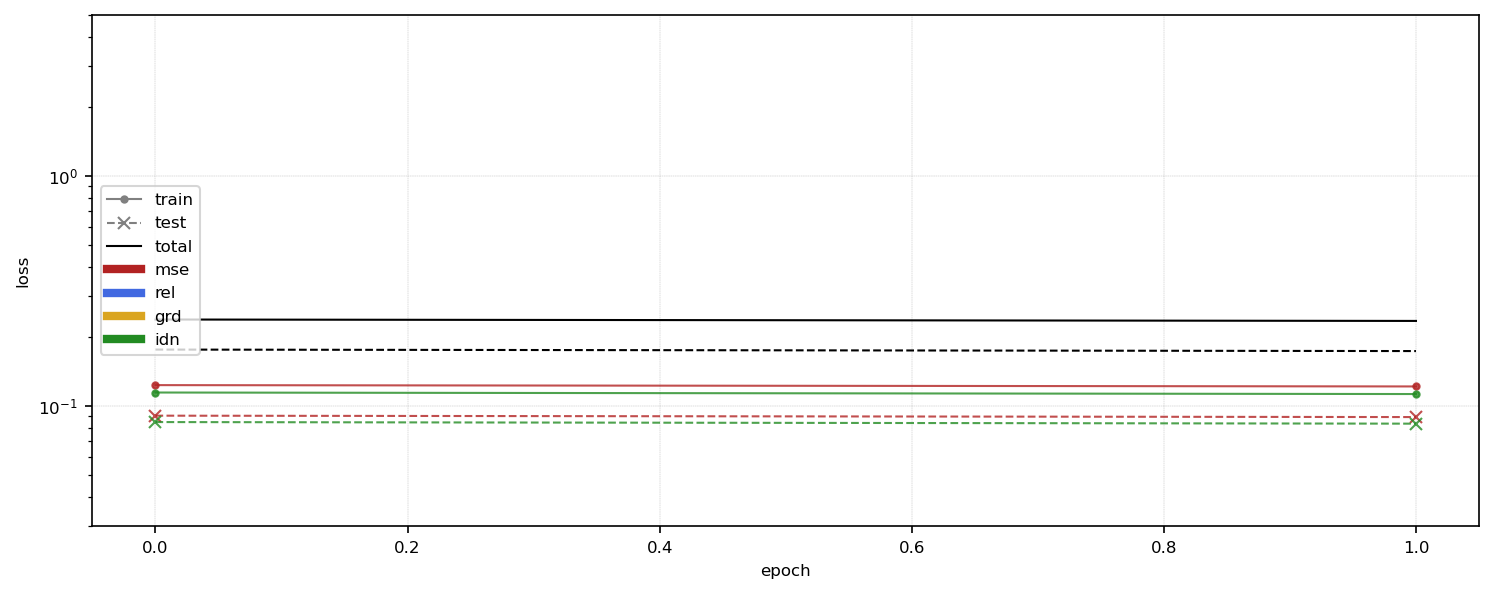

In [58]:
fig = pl.plot_loss(trainloss, testloss, log = True, ylim = True, limits = [3e-2,5e0])

plt.show()

### Testing & visualising integrated training

In [185]:
outloc  = '/STER/silkem/MACE/models/CSE_0D/old/'
print(train.path)

## other learning rates
dirname = '2023-12-13 18:19:22.522359'  ## lr = 1.e-4       GOOD MODEL

meta, model = utils.load_all_noevol(outloc, dirname, sepr = True, epoch = 7)   # type: ignore
tstep_evol = 64

for i, (n,p,dt) in enumerate(data_loader):
    # print(n.shape, p.shape, dt.shape)
    n  = n.view(n.shape[1], n.shape[2]).to(DEVICE)     ## op een niet-CPU berekenen als dat er is op de device
    p  = p.view(p.shape[1], p.shape[2]).to(DEVICE) 
    dt = dt.view(dt.shape[1]).to(DEVICE)

    # print(n.shape, p.shape, dt.shape)

   
    n0 = n[0:-tstep_evol]
    p0 = p[0:-tstep_evol]
    dt0 = dt[0:-tstep_evol]

    # print(n0.shape, p0.shape, dt0.shape)

    nhat_evol = list()
    n_evol = list()
    
    n_hat, z_hat, modstatus = model(n0[:-1],p0,dt0)   
    n_hat = n_hat.view(-1, 468)
    nhat_evol.append(n_hat)
    n_evol.append(n[0:-tstep_evol+0][:-1])

    print(n_hat.shape)

    ## subsequent steps of the evolution
    for i in range(1,tstep_evol):
        n_hat,z_hat, modstatus = model(n_hat,p[i:-tstep_evol+i],dt[i:-tstep_evol+i])   
        # print('shape nhat',n_hat.shape)
        n_hat = n_hat.view(-1, 468) 
        nhat_evol.append(n_hat)
        n_evol.append(n[i:-tstep_evol+i][:-1])

    nhat_evol = torch.stack(nhat_evol).permute(1,0,2)
    n_evol = torch.stack(n_evol).permute(1,0,2)

    # print(nhat_evol.shape, n_evol.shape)

    nhat_evol = nhat_evol.detach().numpy()
    n_evol = n_evol.detach().numpy()
    n = n.detach().numpy()


['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v10_T_eps/models/model_2022-12-23h17-45-41/csfrac_smooth.out']
The model has 76388 trainable parameters
torch.Size([70, 468])


In [16]:
nhat_evol.shape, n_evol.shape

((112, 22, 468), (112, 22, 468))

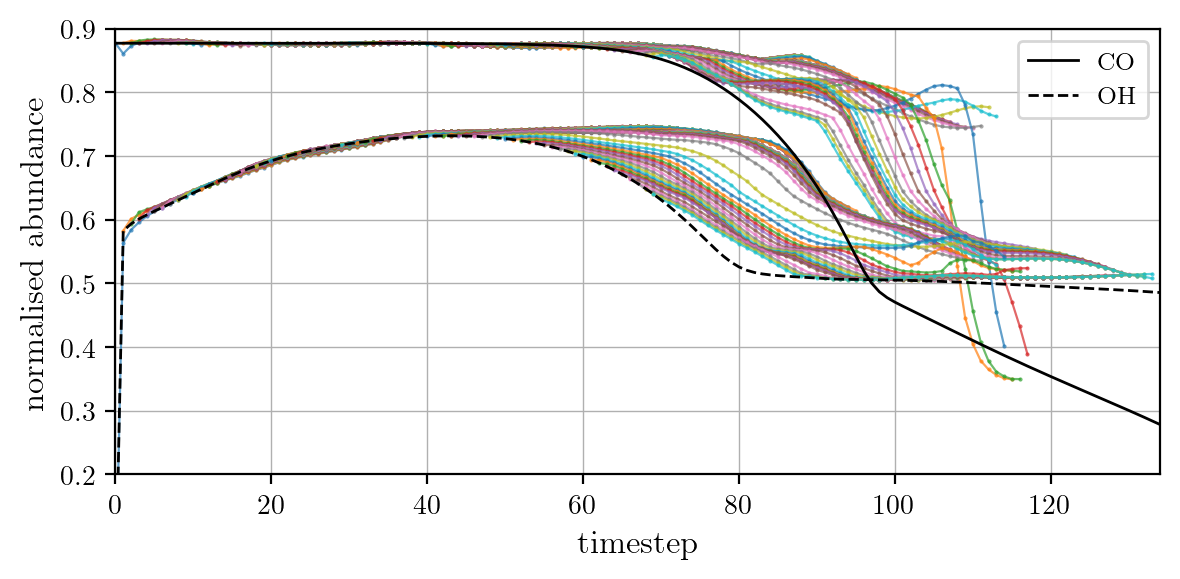

In [186]:
fig, ax1 = plt.subplots(figsize=(6,3))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

specs = ['CO', 'OH']


# ax1.set_title('Integrated MSE training')

ms = 0.5
lw = 0.8

if tstep_evol == 1:
    ms = 1.5

for spec in specs:
    idx = specs_dict[spec]

    for j in range(0,nhat_evol.shape[0]):
        n_sample_hat = nhat_evol[j]
        # print(j,n_sample_hat.shape, n[j].shape)
        n_sample_hat = np.concatenate((n[j].reshape(-1,len(n[j])),n_sample_hat))
        # print(j,n_sample_hat.shape, n[j].shape)
        n_sample = n_evol[j]
        ax1.plot(np.arange(j,j+tstep_evol+1),n_sample_hat.T[idx],'-o', alpha = 0.7, lw =lw, ms = ms)
        # ax1.plot(np.arange(j,j+tstep_evol), n_sample.T[idx])

idx = specs_dict['CO']
ax1.plot(n.T[idx], 'k-', lw = 1, label = 'CO')
idx = specs_dict['OH']
ax1.plot(n.T[idx], 'k--', lw = 1, label = 'OH')


ax1.set_xlabel('timestep',fontsize = 12)
ax1.set_ylabel('normalised abundance',fontsize = 12)

ax1.grid(True, linestyle = '-', linewidth = 0.5)

ax1.set_ylim(0.2,0.9)

ax1.set_xlim(0,134)

ax1.legend(fontsize = 9)
plt.tight_layout()
plt.savefig('figs/visualisation_integrated_training_'+str(tstep_evol), dpi = 300)
plt.show()


### Testing trained models

In [150]:
len(train.testpath), train.testpath

(3000,
 ['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v2-5_T_eps/models/model_2022-12-26h13-44-39/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-8_v7-5_T_eps/models/model_2022-12-27h05-54-13/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20210521_gridC_Mdot5e-5_v25_T_eps/models/model_2022-12-25h13-41-58/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-6_v20_T_eps/models/model_2022-12-27h13-16-10/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-8_v5_T_eps/models/model_2022-12-27h15-59-44/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-8_v7-5_T_eps/models/model_2022-12-27h18-06-22/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot2e-7_v17-5_T_eps/models/model_2022-12-28h13-40-55/csfrac_smooth.out',
  '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v17-5_T_eps/models/model_2023-01-16h16-23-48/csfrac_smooth.o

The model has 284692 trainable parameters

META DATA
nb_samples 10000
lr 0.0001
epochs 100
z_dim 8
dt_fract 0.221
tmax 434800000000.0
train_time_h 13.24076943702168
overhead_s 0.650787353515625
samples 7000
cutoff_abs 1e-20
losstype mse_idn_evo
inputfile old/input_mse_evo_idn7
nb_hidden 1
ae_type simple
node pleiad15
done true

 Parameters tests:
-- 1e-06 -- 17.5 --
dens -12.243038048686294
temp 0.5 2100.0
     93.91485505499116
--



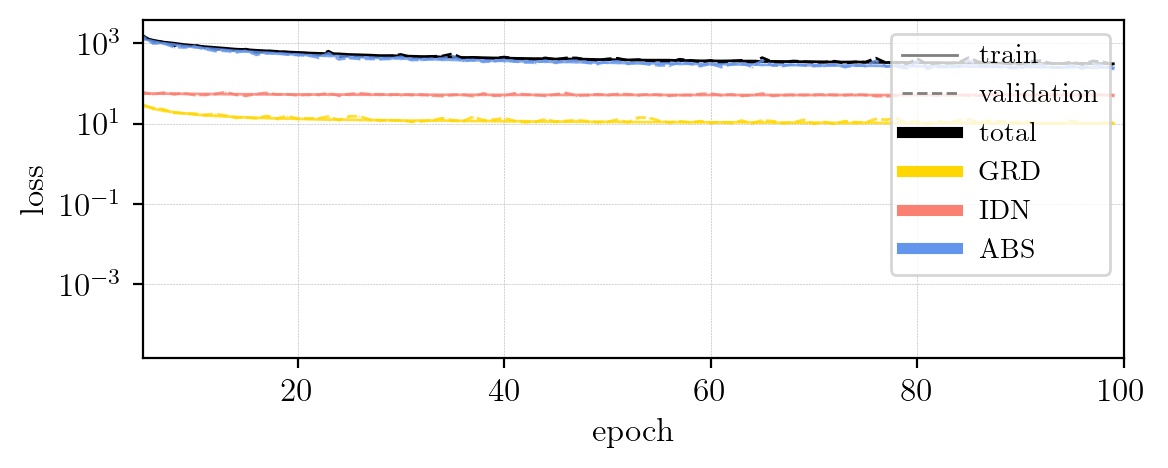

In [39]:
outloc  = '/STER/silkem/MACE/models/CSE_0D/'



## other learning rates
# dirname = '2023-12-13 18:19:22.522359'  ## lr = 1.e-4       GOOD MODEL

## local training
### prototype models (pt)
# dirname = '2024-01-03 12:39:49.464495'          # pt3
# dirname = '2024-01-03 12:39:43.621115_done'     # pt2
# dirname = '2024-01-02 21:42:45.793085_done'     # pt1

### loc
# dirname = '20240103_151253_58677_5'
# dirname = '20240103_235005_58677_7'
# meta, model_testing, trainloss_, testloss_ = utils.load_all_noevol(outloc, dirname) # type: ignore


## grid
# dirname = '20240207_093243_66618_1'
# dirname = '20240207_134859_66656_2'
# dirname = '20240208_135604_66879_7'

# epoch = '14'

## local new
dirname = '20240305_123238_103131_7'

epoch =''

meta, model_testing, trainloss_, testloss_ = utils.load_all(outloc, dirname, epoch = epoch) # type: ignore


print('\nMETA DATA')
for key in meta:
    print(key, meta[key])
    
plots_path = outloc+dirname+'/plots/'
utils.makeOutputDir(plots_path)

if not os.path.exists(outloc+dirname+"/testloss.json"):
    testloss = {}
    json_loss = json.dumps(testloss, indent=4)
    with open(outloc+dirname+"/testloss.json", "w") as outfile:
        outfile.write(json_loss)

# testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-8_v2-5_T_eps/models/model_2022-12-26h16-02-06/csfrac_smooth.out',
#              '/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v17-5_T_eps/models/model_2022-12-24h17-06-51/csfrac_smooth.out',
#              '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-5_v22-5_T_eps/models/model_2022-12-27h11-01-25/csfrac_smooth.out']

# testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h21-58-23/csfrac_smooth.out', 
#              '/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-30-08/csfrac_smooth.out',
#              '/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-25h00-33-02/csfrac_smooth.out']

# testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-8_v25_T_eps/models/model_2022-12-27h02-04-49/csfrac_smooth.out']

# testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v5_T_eps/models/model_2022-12-23h17-12-12/csfrac_smooth.out']
        
## check for difference in chem, same dens
# testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v5_T_eps/models/model_2022-12-24h12-55-54/csfrac_smooth.out',
#              '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot5e-7_v12-5_T_eps/models/model_2022-12-27h12-24-10/csfrac_smooth.out',
#              '/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v20_T_eps/models/model_2022-12-28h20-53-28/csfrac_smooth.out'
#              ]
# testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20210518_gridC_Mdot1e-8_v2-5_T_eps/models/model_2022-12-24h23-30-08/csfrac_smooth.out', 
#              '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-31-58/csfrac_smooth.out', 
#               '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-8_v12-5_T_eps/models/model_2022-12-25h01-00-03/csfrac_smooth.out']

# testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v15_T_eps/models/model_2022-12-28h14-44-08/csfrac_smooth.out']

testpaths = ['/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v17-5_T_eps/models/model_2022-12-24h17-06-51/csfrac_smooth.out']

print('\n Parameters tests:')
for path in testpaths:
    # print(path)
    mod = ds.CSEmod(path)
    print('--', mod.Mdot,'--',mod.v/1e5, '--')
    print('dens', np.log10(mod.Mdot/mod.v))
    print('temp',mod.eps, mod.Tstar)
    print('    ', temp( mod.Tstar, mod.eps, 1e16))
    print('--')
    print()

fig = pl.plot_loss(trainloss_, testloss_, log = True, ylim = False, limits = [5e-2,1e0])#, notest = False)
plt.savefig(plots_path+'loss.png')

In [7]:
def test_model(model_testing, testpaths, specs_lg, specs, plots_path, epoch, save = False, plotting = False):
    # testpaths = train.testpath

    # testpaths = natsorted(testpaths)

    avg_step = list()
    std_step = list()
    sum_step = list()

    avg_evol = list()
    std_evol = list()
    sum_evol = list()

    mods = list()


    for i, testpath in enumerate(testpaths):
        print(i,testpath)
        input, info = ds.get_test_data(testpath,train)

        model1D = ds.CSEmod(testpath)
        r = model1D.radius
        rho = model1D.get_dens()
        T = model1D.get_temp()

        save = True
        title = info['path'] +'_'+ info['name']
        mods.append(title)

        n, n_hat, t, comptime = tr.test(model_testing, input)
        start_idx = 0
        n_evol, mace_time, idv_time  = tr.test_evolution(model_testing, input, start_idx=start_idx)

        print('\n>> Denormalising abundances...')
        n = ds.get_abs(n)
        n_hat = ds.get_abs(n_hat)
        n_evol = ds.get_abs(n_evol)

        print('\n>> Calculating & saving losses...')
        # print('per time step:')
        mse = loss.mse_loss(n[1:], n_hat)
        avg_step.append(mse.mean())
        std_step.append(mse.std())
        sum_step.append(mse.sum())
        losses_step = [mse.mean(), mse.std(), mse.sum()]

        # print('    evolution:')
        mse_evol = loss.mse_loss(n[1:], n_evol)
        avg_evol.append(mse_evol.mean())
        std_evol.append(mse_evol.std())
        sum_evol.append(mse_evol.sum())
        losses_evol = [mse_evol.mean(), mse_evol.std(), mse_evol.sum()]

        testloss = {title: losses_step,
                    title: losses_evol,
                    }
        
        with open(outloc+dirname+"/testloss.json", "r") as outfile:
            testloss_old = json.load(outfile)
        testloss_old.update(testloss)
        # print(testloss_old)
        with open(outloc+dirname+"/testloss.json", "w") as outfile:
            json.dump(testloss_old, outfile, indent=4)

        # plotting = False
        if plotting == True:
            print('\n>> Plotting...')

            ## --------------- Neural model - per time step ----------------- ##
            # pl.plot_compare(n, n_hat, plots_path, 'comp_timestep_'+title, alpha = 0.5, j = -1, save=True)
            pl.plot_abs( r,n, n_hat, plots_path, rho,T,'timestep_'+title+'_'+epoch,specs_lg, specs=specs, save=save, step = True)

            ## --------------- Neural model - evolution ----------------- ##

            # pl.plot_compare(n, n_evol, plots_path, 'comp_evolution_'+title, alpha = 0.5, j = -1, save=True)
            pl.plot_abs( r,  n, n_evol, plots_path, rho, T, 'evolution_'+title+'_'+epoch,specs_lg,specs=specs, save=save)

        print('Done!')
        print('----------------------------------------\n')

    return np.array(avg_step), np.array(std_step), np.array(sum_step), np.array(avg_evol), np.array(std_evol), np.array(sum_evol), mods

________20240305_123238_103131_7_______________________________________________


0 /lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v17-5_T_eps/models/model_2022-12-24h17-06-51/csfrac_smooth.out
         Solving time [s]: 0.7770087718963623
         Total   time [s]: 0.7796328067779541

>> Denormalising abundances...

>> Calculating & saving losses...

>> Plotting...
Done!
----------------------------------------



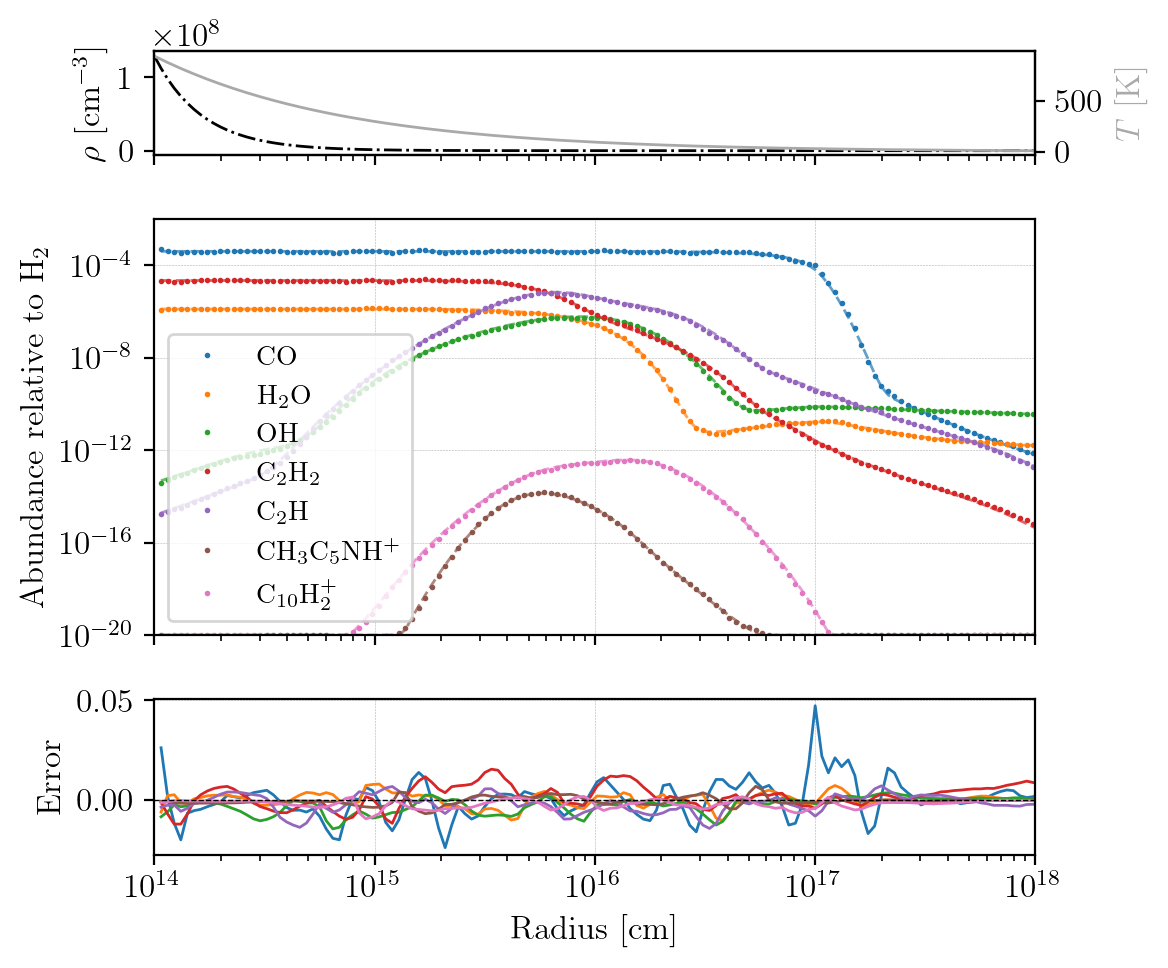

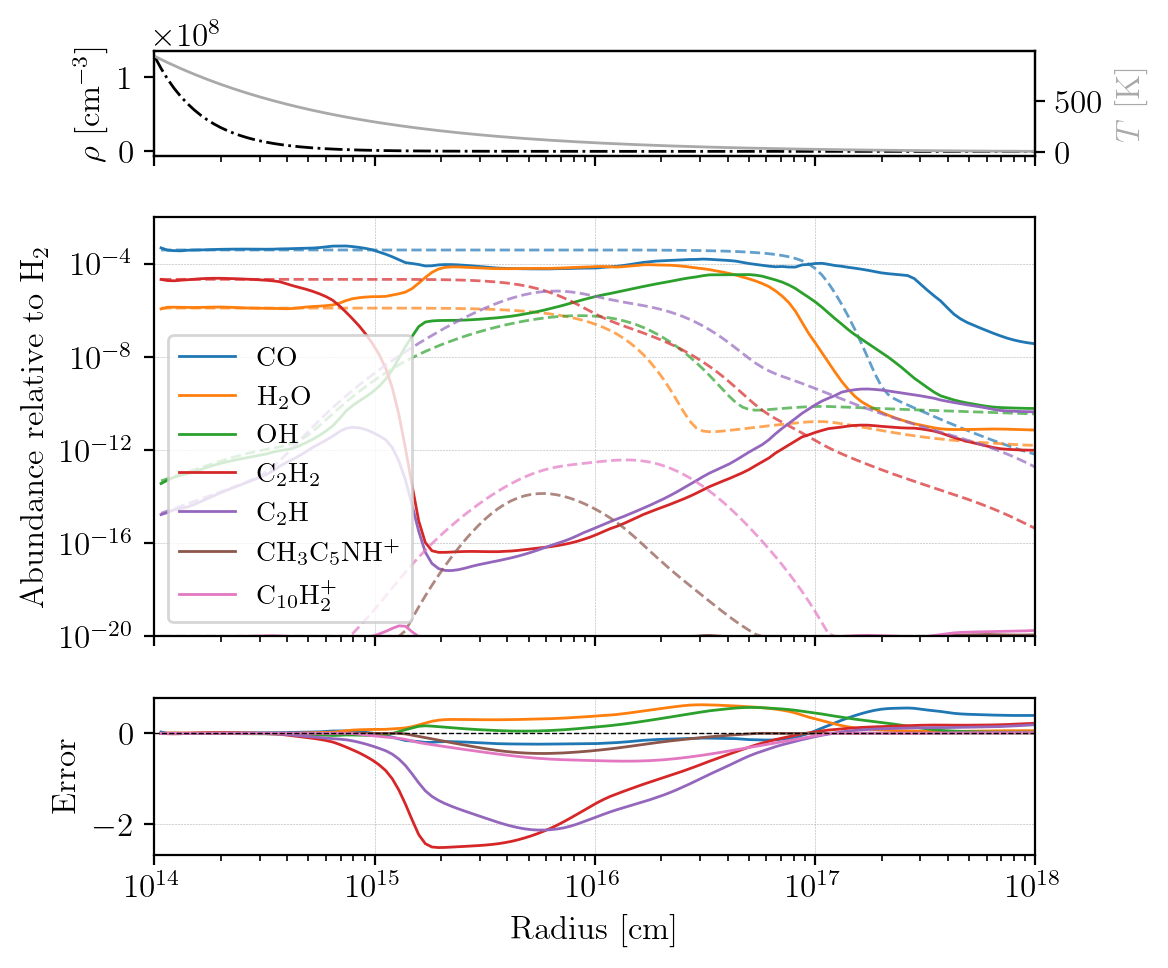

In [15]:
print('________'+dirname+'___________'+epoch+'____________________________________\n\n')

specs = ['CO', 'H2O','OH',  'C2H2',  'C2H', 'CH3C5NH+', 'C10H2+']
specs_lg = {'CO': 'CO', 'H2O': 'H$_2$O','OH': 'OH',  'C2H2': 'C$_2$H$_2$',  'C2H': 'C$_2$H', 'CH3C5NH+': 'CH$_3$C$_5$NH$^+$', 'C10H2+': 'C$_{10}$H$_2^+$'}

plots_path = outloc+dirname+'/plots/'
utils.makeOutputDir(plots_path)

if not os.path.exists(outloc+dirname+"/testloss.json"):
    testloss = {}
    json_loss = json.dumps(testloss, indent=4)
    with open(outloc+dirname+"/testloss.json", "w") as outfile:
        outfile.write(json_loss)

avg_step, std_step, sum_step, avg_evol, std_evol, sum_evol, mods = test_model(model_testing, testpaths, specs_lg,specs, plots_path, epoch,save = True, plotting = True)
    

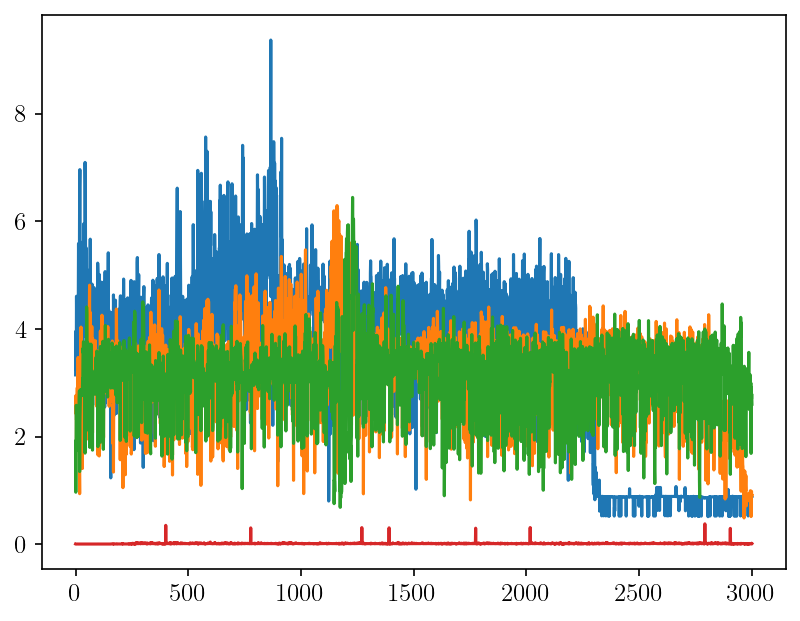

In [6]:
dirname = '20240106_102404_58729_3'
outloc  = '/STER/silkem/MACE/models/CSE_0D/'

time = np.load(outloc+dirname+'/calctime_evol_3002.npy')
plt.plot(time)


dirname = '20240106_102404_58729_4'
time = np.load(outloc+dirname+'/calctime_evol_3002.npy')
plt.plot(time)

dirname = '20240106_102404_58729_2'
time = np.load(outloc+dirname+'/calctime_evol_3002.npy')
plt.plot(time)

dirname = '20240109_173711_59121_1'
time = np.load(outloc+dirname+'/calctime_evol_3002.npy')
plt.plot(time)

evol [ 77.67770461  87.41399216  64.17222482 102.79591709]
step [3.47070616 2.63442771 2.62946901 2.24901985]


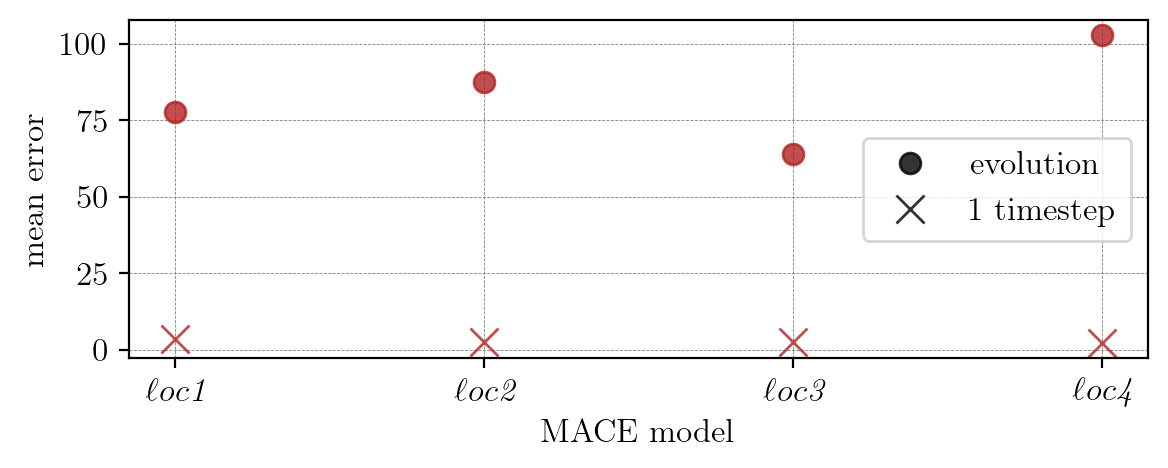

In [16]:
## LOCAL MODELS SUMMED MSE

# idx = ['1', '3', '5']
outloc  = '/STER/silkem/MACE/models/CSE_0D/'

x = np.linspace(1,22,22)

fig = plt.figure(figsize = (6,2.5))
ax1 = fig.add_subplot((111))
lw = 0.5
handles = list()
losses_evol = list()
losses_step = list()    
log_err_evol = list()
dirs = list()

# ax1.set_title('Runs:58677')

idx = ['5']
for i in range(len(idx)):
    dirname = '20240103_151253_58677_'+idx[i]
    dirs.append(dirname)
    logerr = np.load(outloc+dirname+'/testloss_step_logerr_3000.npy')
    losses_step.append(float(logerr))
    logerr = np.load(outloc+dirname+'/testloss_evol_logerr_3000.npy')
    losses_evol.append(float(logerr))

dirname = '20240103_235005_58677_7'
dirs.append(dirname)
logerr = np.load(outloc+dirname+'/testloss_step_logerr_3000.npy')
losses_step.append(float(logerr))
logerr = np.load(outloc+dirname+'/testloss_evol_logerr_3000.npy')
losses_evol.append(float(logerr))


idx = ['1','3']
for i in range(len(idx)):
    dirname = '20240103_151253_58677_'+idx[i]
    dirs.append(dirname)
    logerr = np.load(outloc+dirname+'/testloss_step_logerr_3000.npy')
    losses_step.append(float(logerr))
    logerr = np.load(outloc+dirname+'/testloss_evol_logerr_3000.npy')
    losses_evol.append(float(logerr))

nb_models = 3000*134

losses_evol = np.array(losses_evol)/nb_models
losses_step = np.array(losses_step)/nb_models

print('evol',losses_evol)
print('step',losses_step)

ms = 15
a=0.8
ax1.plot(losses_evol, '.',label='evolution', c='firebrick', ms=ms, alpha =a)
ax1.plot( losses_step, 'x',label='per time step local', c='firebrick', ms =ms-5, alpha =a)
# ax1.plot(log_err_evol, 'v',label='log error', c='green', ms =ms, alpha =a)
# ax1.plot(losses_step, 'v',label='per time step', c='steelblue', ms =ms, alpha =a)

ax1.set_ylabel('mean error')

x = np.linspace(0,len(dirs)-1,len(dirs))
ax1.xaxis.set_major_locator(FixedLocator(x))
ax1.set_xticklabels(['$\\ell oc$\\emph{1}', '$\\ell oc$\\emph{2}', '$\\ell oc$\\emph{3}', '$\\ell oc$\\emph{4}'], rotation=0, fontsize = 12)
ax1.set_xlabel('MACE model')

ax1.grid(True, linestyle='--', linewidth=0.3, color='gray')

# ax1.set_ylim(10**0,10**13)
# ax1.set_yscale('log')

l_evol = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = '.', label='evolution',ms =ms, alpha = a)
l_step = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = 'x', label='1 timestep',ms =ms-5, alpha = a)
    
handles = [l_evol, l_step]
plt.legend(handles = handles, fontsize = 12, loc='center right')
plt.rcParams.update({'font.size': 12})  
plt.tight_layout()
plt.savefig('losses_58677.png', dpi = 300)

plt.show()

evol [76.68799886 87.5607769  55.54142816 53.3209236 ]
step [2.26043429 1.44925118 2.06095274 1.52549689]


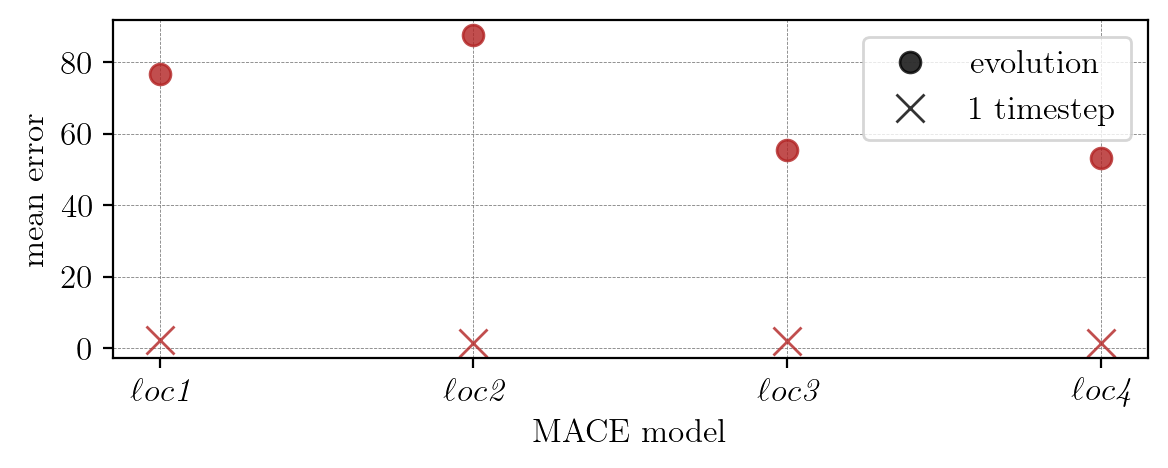

In [31]:
## NEW LOCAL MODELS SUMMED MSE

# idx = ['1', '3', '5']
outloc  = '/STER/silkem/MACE/models/CSE_0D/'

x = np.linspace(1,22,22)

fig = plt.figure(figsize = (6,2.5))
ax1 = fig.add_subplot((111))
lw = 0.5
handles = list()
losses_evol = list()
losses_step = list()    
log_err_evol = list()
dirs = list()

# ax1.set_title('Runs:58677')

idx = ['5', '7', '1', '3']
for i in range(len(idx)):
    dirname = '20240305_123238_103131_'+idx[i]
    dirs.append(dirname)
    logerr = np.load(outloc+dirname+'/testloss_step_logerr_3000.npy')
    losses_step.append(float(logerr))
    logerr = np.load(outloc+dirname+'/testloss_evol_logerr_3000.npy')
    losses_evol.append(float(logerr))



nb_models = 3000*134

losses_evol = np.array(losses_evol)/nb_models
losses_step = np.array(losses_step)/nb_models

print('evol',losses_evol)
print('step',losses_step)

ms = 15
a=0.8
ax1.plot(losses_evol, '.',label='evolution', c='firebrick', ms=ms, alpha =a)
ax1.plot( losses_step, 'x',label='per time step local', c='firebrick', ms =ms-5, alpha =a)
# ax1.plot(log_err_evol, 'v',label='log error', c='green', ms =ms, alpha =a)
# ax1.plot(losses_step, 'v',label='per time step', c='steelblue', ms =ms, alpha =a)

ax1.set_ylabel('mean error')

x = np.linspace(0,len(dirs)-1,len(dirs))
ax1.xaxis.set_major_locator(FixedLocator(x))
ax1.set_xticklabels(['$\\ell oc$\\emph{1}', '$\\ell oc$\\emph{2}', '$\\ell oc$\\emph{3}', '$\\ell oc$\\emph{4}'], rotation=0, fontsize = 12)
ax1.set_xlabel('MACE model')

ax1.grid(True, linestyle='--', linewidth=0.3, color='gray')

# ax1.set_ylim(10**0,10**13)
# ax1.set_yscale('log')

l_evol = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = '.', label='evolution',ms =ms, alpha = a)
l_step = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = 'x', label='1 timestep',ms =ms-5, alpha = a)
    
handles = [l_evol, l_step]
plt.legend(handles = handles, fontsize = 12, loc='upper right')
plt.rcParams.update({'font.size': 12})  
plt.tight_layout()
plt.savefig('figs/losses_103131.png', dpi = 300)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/STER/silkem/MACE/models/CSE_0D/20240207_134859_66656_1/2testloss_evol_logerr_3000.npy'

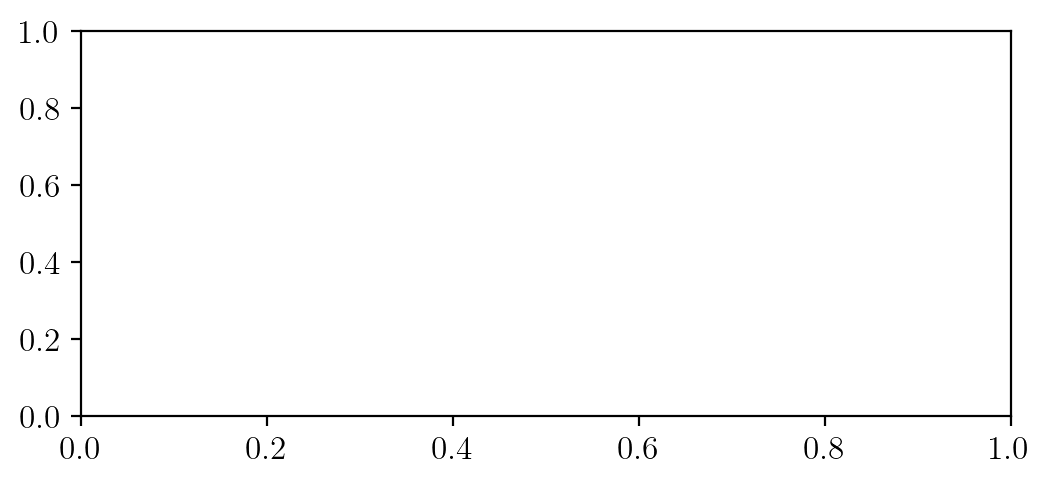

In [36]:
## INTEGRATED MODELS MODELS SUMMED MSE

idx1 = ['2','3', '4', '5']
# idx1 = ['1', '3']
idx2 = ['6','7','8','9']
# idx3 = ['13', '14']
idx = []
outloc  = '/STER/silkem/MACE/models/CSE_0D/'

x = np.linspace(1,22,22)

# fig = plt.figure(figsize = (10,2.5))
fig = plt.figure(figsize = (6,2.5))
ax1 = fig.add_subplot((111))
# ax2 = ax1.twinx()

lw = 0.5
handles = list()
losses_evol = list()
losses_evol_14 = list()
losses_step = list()    
dirs = list()
train_times = [0.5,0.52,0.8,0.79,0.82,1.37,1.34,1.33,2.37]

## ------------------ integrated models ------------------ ##


dirname = '20240207_093243_66618_1'
dirs.append(dirname)
idx.append('1')
# logerr = np.load(outloc+dirname+'/testloss_evol_logerr_3000.npy')
# losses_evol.append(float(logerr))
logerr = np.load(outloc+dirname+'/2testloss_evol_logerr_3000.npy')
losses_evol_14.append(float(logerr))
logerr = np.load(outloc+dirname+'/2testloss_step_logerr_3000.npy')
losses_step.append(float(logerr))
meta = utils.load_meta(outloc, dirname)

for i in range(len(idx1)):
    dirname = '20240207_134859_66656_'+idx1[i]
    dirs.append(dirname)
    idx.append(idx1[i])
    # logerr = np.load(outloc+dirname+'/testloss_evol_logerr_3000.npy')
    # losses_evol.append(float(logerr))
    logerr = np.load(outloc+dirname+'/2testloss_evol_logerr_3000.npy')
    losses_evol_14.append(float(logerr))
    logerr = np.load(outloc+dirname+'/2testloss_step_logerr_3000.npy')
    losses_step.append(float(logerr))
    meta = utils.load_meta(outloc, dirname)
    

for i in range(len(idx2)):
    dirname = '20240208_135604_66879_'+idx2[i]
    dirs.append(dirname)
    idx.append(idx1[i])
    # logerr = np.load(outloc+dirname+'/testloss_evol_logerr_3000.npy')
    # losses_evol.append(float(logerr))
    logerr = np.load(outloc+dirname+'/2testloss_evol_logerr_3000.npy')
    losses_evol_14.append(float(logerr))
    logerr = np.load(outloc+dirname+'/2testloss_step_logerr_3000.npy')
    losses_step.append(float(logerr))
    meta = utils.load_meta(outloc, dirname)
#     


## ------------------ comparison with local models ------------------ ##

losses_evol_local = list()
losses_step_local = list()  

idx = ['5']
for i in range(len(idx)):
    dirname = '20240103_151253_58677_'+idx[i]
    dirs.append(dirname)
    logerr = np.load(outloc+dirname+'/testloss_evol_logerr_3000.npy')
    losses_evol_local.append(float(logerr))
    logerr = np.load(outloc+dirname+'/testloss_step_logerr_3000.npy')
    losses_step_local.append(float(logerr))


dirname = '20240103_235005_58677_7'
dirs.append(dirname)
logerr = np.load(outloc+dirname+'/testloss_evol_logerr_3000.npy')
losses_evol_local.append(float(logerr))    
logerr = np.load(outloc+dirname+'/testloss_step_logerr_3000.npy')
losses_step_local.append(float(logerr))

idx = ['1','3']
for i in range(len(idx)):
    dirname = '20240103_151253_58677_'+idx[i]
    dirs.append(dirname)
    logerr = np.load(outloc+dirname+'/testloss_evol_logerr_3000.npy')
    losses_evol_local.append(float(logerr))
    logerr = np.load(outloc+dirname+'/testloss_step_logerr_3000.npy')
    losses_step_local.append(float(logerr))


## --------------- normalise --------------- ##
nb_test = 3000*134
losses_evol_local = np.array(losses_evol_local)/nb_test
losses_step_local = np.array(losses_step_local)/nb_test
losses_evol = np.array(losses_evol)/nb_test
losses_step = np.array(losses_step)/nb_test
losses_evol_14 = np.array(losses_evol_14)/nb_test


idx = ['5', '7', '1', '3']

# print(losses_evol)
len_int = 1+len(idx1)+len(idx2)
# print(len_int)
x = np.linspace(len_int,len_int+len(idx)-1,len(idx))
ms = 15
a = 1

# ax2.plot(train_times, 's', color = 'goldenrod',label = 'training time', ms = ms-8, alpha = 0.7)
## integrated
# ax1.plot(losses_evol, '.',label='evolution', c='steelblue', ms=ms, alpha =a)
ax1.plot(losses_step, 'x',label='per time step', c='steelblue', ms =ms-5, alpha =a)
ax1.plot(losses_evol_14, '.',label=' evol - 150 epoch', c='steelblue', ms=ms, alpha =a)
## local
# ax1.plot(x, losses_evol_local, '.',label='evolution local', c='firebrick', ms=ms, alpha =a)
# ax1.plot(x, losses_step_local, 'x',label='per time step local', c='firebrick', ms =ms-5, alpha = a)


print('----- integrated')
print('step',losses_step)
print('evol',losses_evol)
print('evol14',losses_evol_14)
print('----- local')
print('step',losses_step_local)
print('evol',losses_evol_local)


ax1.set_ylabel('mean error')

# x = np.linspace(0,len_int+len(idx)-1,len_int+len(idx))
x = np.linspace(0,len_int-1,len_int)
ax1.xaxis.set_major_locator(FixedLocator(x))

xticks = ['$\\emph{int'+str(i)+'}$' for i in range(1,len_int+1)]
# xticks.append('$\\ell oc$\\emph{1}')
# xticks.append('$\\ell oc$\\emph{2}')
# xticks.append('$\\ell oc$\\emph{3}')
# xticks.append('$\\ell oc$\\emph{4}')
print(xticks)

ax1.set_xticklabels(xticks)
ax1.set_xlabel('MACE model')
# ax2.set_ylabel('train time [h]', color = 'goldenrod')

ax1.grid(True, linestyle='--', linewidth=0.3, color='grey')
# ax2.grid(True, linestyle='--', linewidth=0.3, color='goldenrod')

# ax1.set_ylim(-5,45)
# ax1.set_yscale('log')

lw = 4
# l_intgr = mlines.Line2D([],[], color = 'steelblue', ls = '-' , label='integrated',lw = lw, alpha = a)
# l_local = mlines.Line2D([],[], color = 'firebrick', ls = '-' , label='local',lw =lw, alpha = a)
l_evol = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = '.', label='evolution',ms =ms, alpha = a)
l_step = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = 'x', label='1 timestep',ms =ms-5, alpha = a)
    
# handles = [l_intgr, l_local, l_evol, l_step]
handles = [l_evol, l_step]
plt.legend(handles = handles, fontsize = 12, loc='center left')
plt.rcParams.update({'font.size': 12})  
plt.tight_layout()
# plt.savefig('error_integrated.png', dpi = 300)



plt.show()

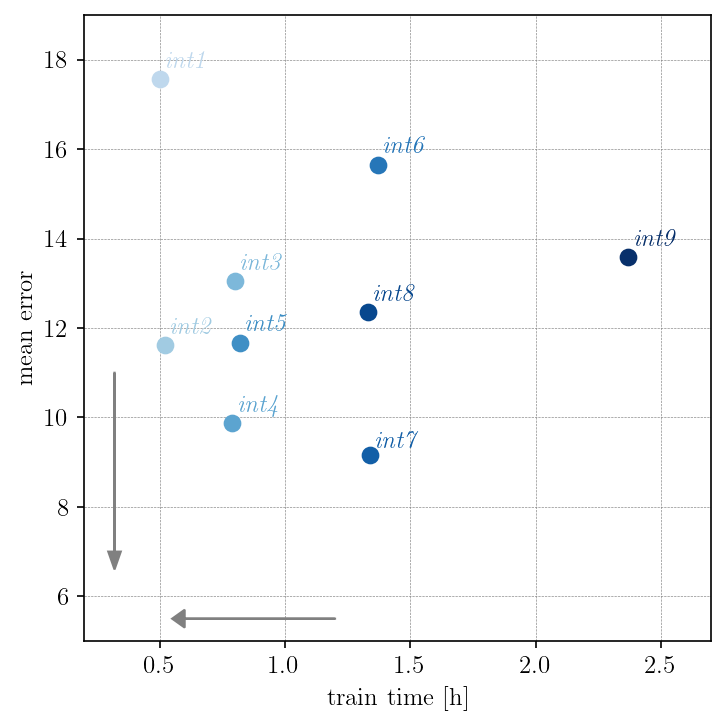

In [171]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot((111))

offset = 3

colors = mpl.cm.Blues(np.linspace(0, 1, offset+len(train_times)))

for i in range(len(train_times)):
    ax1.plot(train_times[i], losses_evol_14[i], '.',c=colors[offset+i], ms=ms, alpha =a)
    ax1.annotate('$\\emph{int'+str(i+1)+'}$',(train_times[i]+0.025, losses_evol_14[i]+0.25),  fontsize = 12,c=colors[offset+i])

# ax1.plot(0,0, 'k.')
# ax1.annotate('classical',(0.025, 0.25),  fontsize = 10)

ax1.arrow(1.2, 5.5 , -0.6, 0, head_width=0.4, head_length=0.05, fc='grey', ec='grey')
ax1.arrow(0.32, 11 , 0, -4, head_width=0.05, head_length=0.4, fc='grey', ec='grey')


ax1.set_ylabel('mean error')
ax1.set_xlabel('train time [h]')

ax1.grid(True, linestyle='--', linewidth=0.3, color='grey')
# ax1.legend()

ax1.set_xlim(0.2,2.7)
ax1.set_ylim(5,19)


plt.tight_layout()

plt.savefig('figs/accuracy_traintime.png', dpi = 300)

plt.show()



________20240106_102404_58729_0_______________________________________________




KeyError: 'nb_hidden'

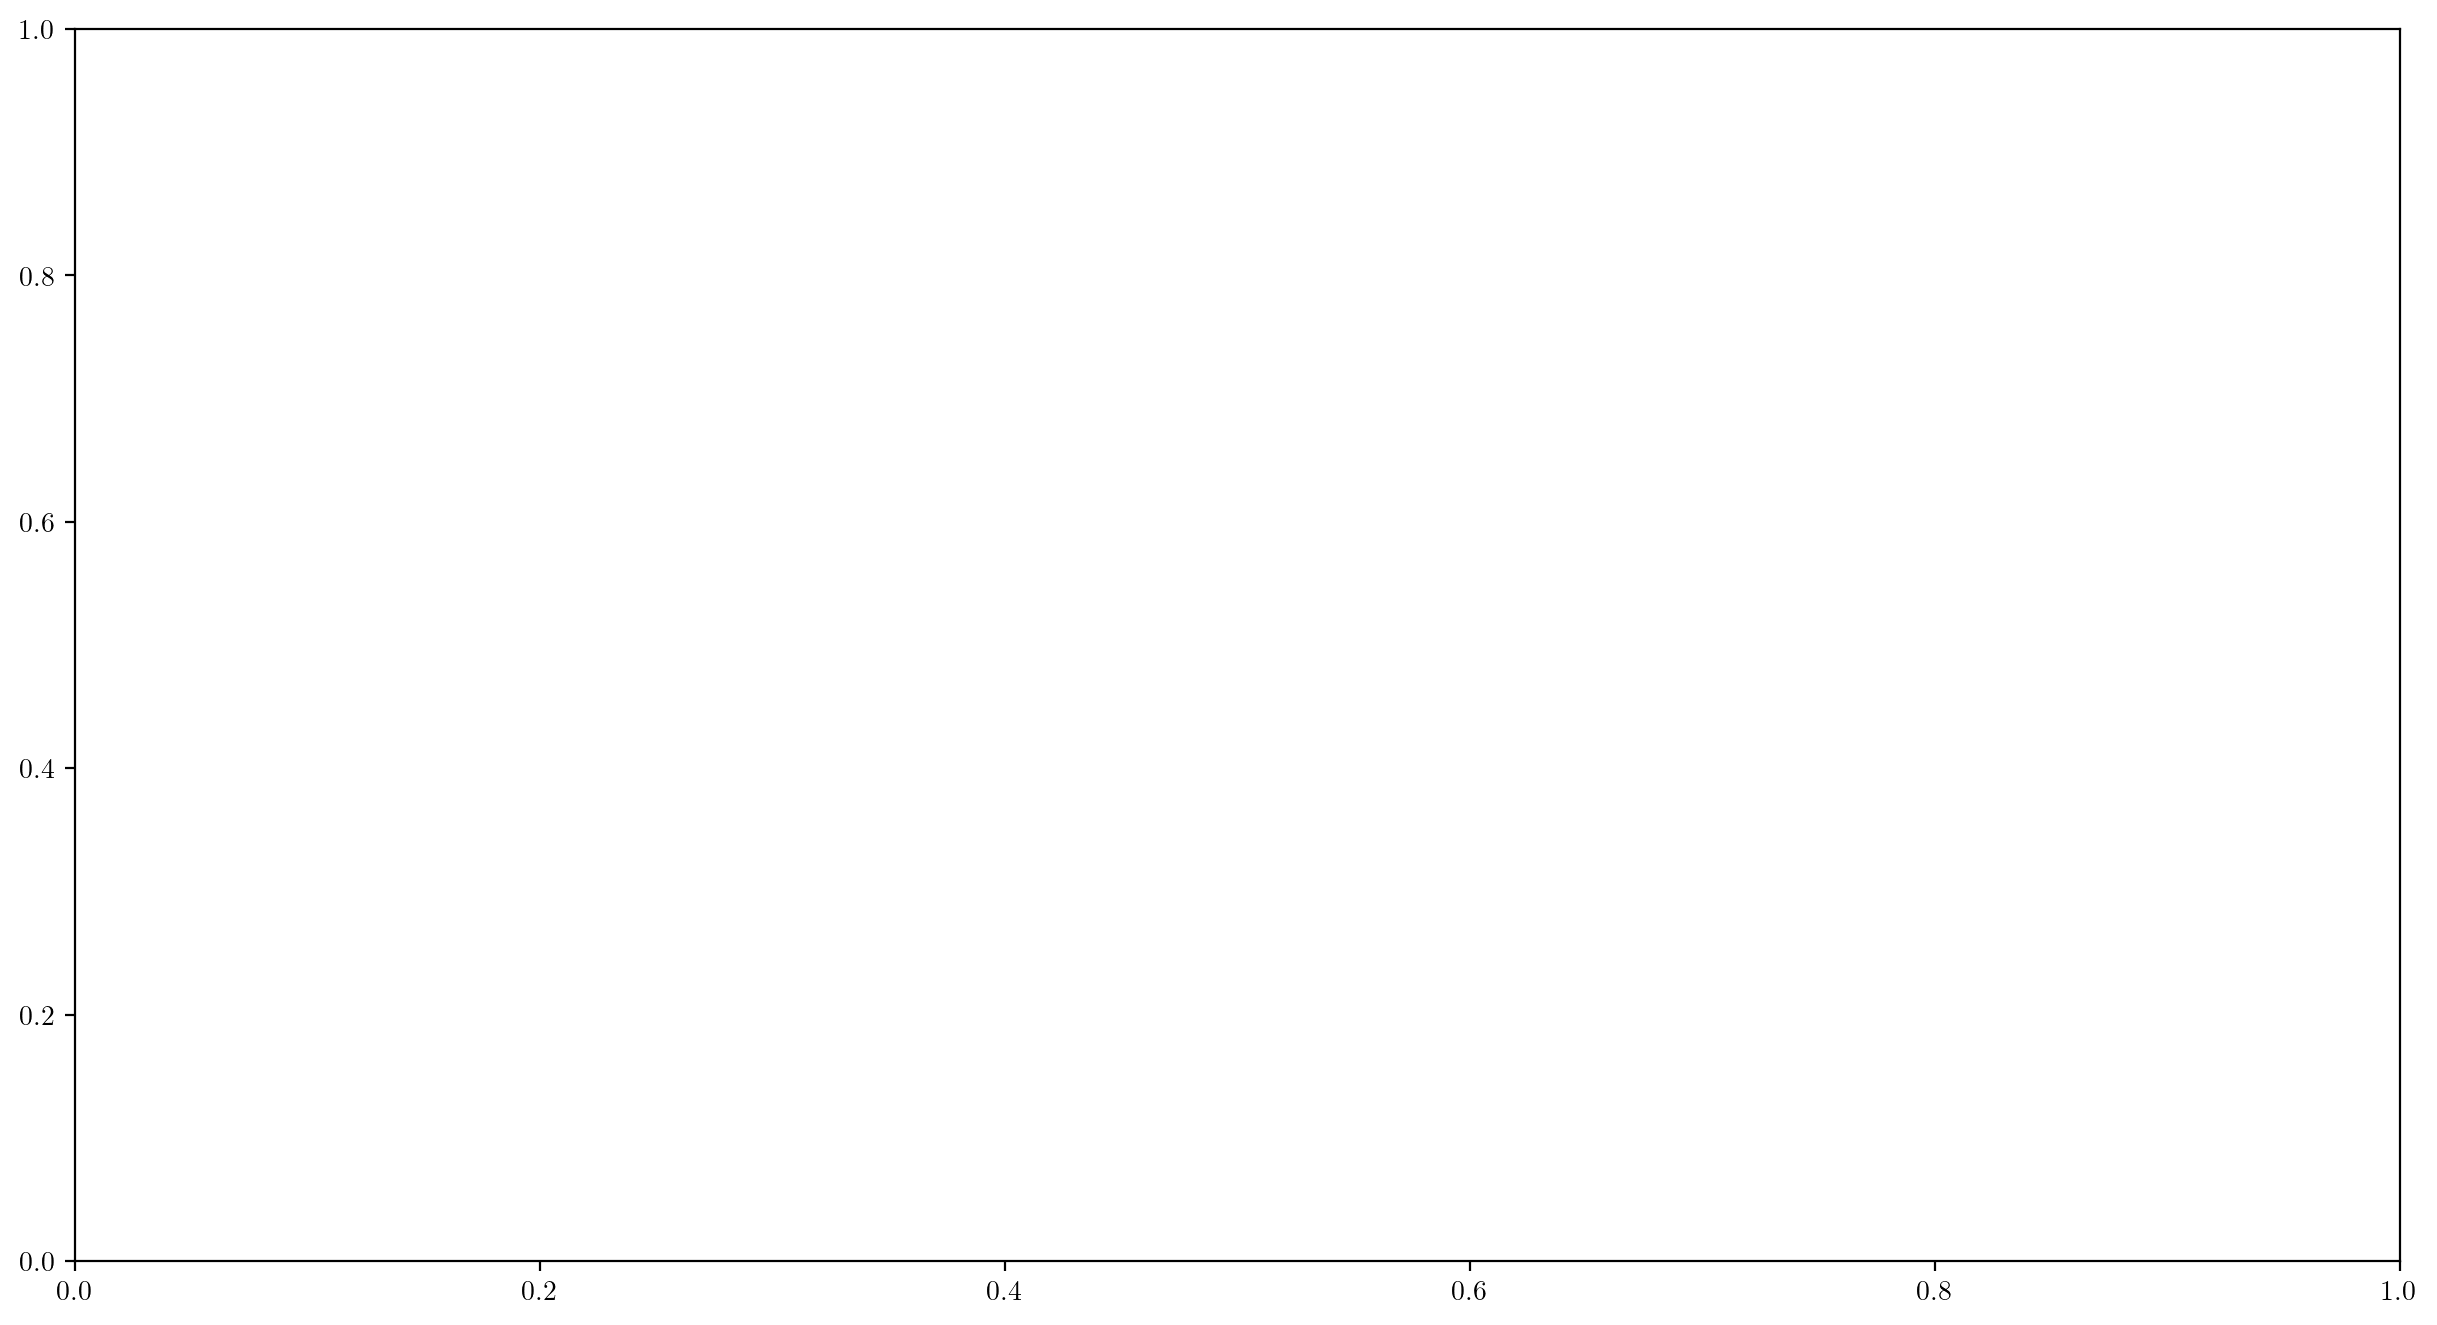

In [180]:
idx = ['0', '1', '2','3', '4', '5', '6']
# idx = ['4', '5', '6']
outloc  = '/STER/silkem/MACE/models/CSE_0D/'

x = np.linspace(1,22,22)

fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot((111))
lw = 0.5
handles = list()

specs = ['CO', 'H2O', 'HCN', 'H2S','C2H2', 'OH', 'CN', 'HS', 'C2H', 'CH3C5NH+']

for i in range(len(idx)):
    dirname = '20240106_102404_58729_'+idx[i]
    print('\n________'+dirname+'_______________________________________________\n\n')

    meta_, model_, trainloss_, testloss_ = utils.load_all(outloc, dirname) # type: ignore
    plots_path = outloc+dirname+'/plots/'
    utils.makeOutputDir(plots_path)

    if not os.path.exists(outloc+dirname+"/testloss.json"):
        testloss = {}
        json_loss = json.dumps(testloss, indent=4)
        with open(outloc+dirname+"/testloss.json", "w") as outfile:
            outfile.write(json_loss)
    
    avg_step, std_step, sum_step, avg_evol, std_evol, sum_evol, mods = test_model(model_, specs = specs, plots_path = plots_path, plotting = False, save = True)
    
    line, = ax1.plot(x,sum_step,marker ='x', linestyle = '--', lw = lw)
    ax1.plot(x,sum_evol,marker ='o', linestyle = '-',color = line.get_color(),  lw = lw)
    leg = mlines.Line2D([],[], color = line.get_color(), ls = '-' , lw = 5, label = idx[i])
    handles.append(leg)

ax1.set_yscale('log')

ax1.set_xlabel('model', fontsize = 10)
ax1.set_ylabel('MSE', fontsize = 10)


ax1.xaxis.set_major_locator(FixedLocator(x))
ax1.set_xticklabels(mods, rotation=90, fontsize = 10)

ax1.grid(True, linestyle='--', linewidth=0.1, color='gray')

l_step = mlines.Line2D([],[], color = 'k', ls = '--' , marker = 'x', label='step', lw = lw)
l_evol = mlines.Line2D([],[], color = 'k', ls = '-' , marker = 'o', label='evol', lw = lw)

handles.append(l_step)
handles.append(l_evol)

plt.legend(handles = handles, fontsize = 10)

plt.tight_layout()
plt.savefig('test_mse.png')
plt.show()

In [1]:
## NIEUWE VERSIE

idx = ['0', '1', '2','3', '4', '5', '6']
# idx = ['4', '5', '6']
outloc  = '/STER/silkem/MACE/models/CSE_0D/'

x = np.linspace(1,22,22)

fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot((111))
lw = 0.5
handles = list()

specs = ['CO', 'H2O', 'HCN', 'H2S','C2H2', 'OH', 'CN', 'HS', 'C2H', 'CH3C5NH+']

for i in range(len(idx)):
    dirname = '20240106_102404_58729_'+idx[i]
    print('\n________'+dirname+'_______________________________________________\n\n')

    testpaths = train.testpath

    # testpaths = natsorted(testpaths)

    avg_step = list()
    std_step = list()
    sum_step = list()

    avg_evol = list()
    std_evol = list()
    sum_evol = list()

    res_step_sum = list()
    res_evol_sum = list()

    mods = list()

    for testpath in testpaths:
        print(testpath)
        meta, model, trainloss_, testloss_ = utils.load_all(outloc, dirname) # type: ignore

        input, info = ds.get_test_data(testpath,train)

        save = True
        title = info['path'] +'_'+ info['name']
        mods.append(title)

        n, n_hat, t, comptime = tr.test(model, input)
        start_idx = 0
        n_evol, mace_time = tr.test_evolution(model, input, start_idx=start_idx)

        print('\n>> Denormalising abundances...')
        n = ds.get_abs(n)
        n_hat = ds.get_abs(n_hat)
        n_evol = ds.get_abs(n_evol)

        res_step = utils.relative_error(n, n_hat)
        res_evol = utils.relative_error(n, n_evol)

        res_step_sum.append(res_step.sum())
        res_evol_sum.append(res_evol.sum())
        

        # specs_dict, idx_specs = utils.get_specs()

        # # for idx in range(res_evol.shape[1]):
        # for idx in range(1,468,50):
        #     plt.plot(res_evol[:,idx], label = str(idx)+' '+idx_specs[idx])
        # plt.legend()
        # plt.yscale('log')

        # # pl.plot_abs(n, n_evol, plots_path,title = '', specs = [], save = False)

        # print(res_evol.shape)
        # print(res_evol.sum())
        # xxx


    line, = ax1.plot(x,res_step_sum,marker ='x', linestyle = '--', lw = lw)
    ax1.plot(x,res_evol_sum,marker ='o', linestyle = '-',color = line.get_color(),  lw = lw)
    leg = mlines.Line2D([],[], color = line.get_color(), ls = '-' , lw = 5, label = idx[i])
    handles.append(leg)

ax1.set_yscale('log')

ax1.set_xlabel('model', fontsize = 10)
ax1.set_ylabel('MSE', fontsize = 10)

from matplotlib.ticker import FixedLocator
ax1.xaxis.set_major_locator(FixedLocator(x))
ax1.set_xticklabels(mods, rotation=90, fontsize = 10)

ax1.grid(True, linestyle='--', linewidth=0.1, color='gray')

l_step = mlines.Line2D([],[], color = 'k', ls = '--' , marker = 'x', label='step', lw = lw)
l_evol = mlines.Line2D([],[], color = 'k', ls = '-' , marker = 'o', label='evol', lw = lw)

handles.append(l_step)
handles.append(l_evol)

plt.legend(handles = handles, fontsize = 10)

plt.tight_layout()
plt.savefig('test_res.png')
plt.show()

NameError: name 'np' is not defined

In [5]:
idx = ['0', '1', '2','3', '4', '5', '6']

outloc  = '/STER/silkem/MACE/models/CSE_0D/'

loss_evol = list()
loss_step = list()
time_evol = list()
time_step = list()

for i in range(len(idx)):
    dirname = '20240106_102404_58729_'+idx[i]
    print('\n'+dirname+'_______________________________________________')  
    
    sum_step = 0
    sum_evol = 0
    evol_calctime = list()
    step_calctime = list()

    for i in range(len(train.testpath)):
        print(i,end='\r')

        testpath = train.testpath[i]
        # print(testpath)

        # print('>> Loading test data...')
        input, info = ds.get_test_data(testpath,train)

        # print('>> Running model')
        n, n_hat, t, mace_step_time = tr.test(model_testing, input)
        step_calctime.append(mace_step_time)
        n_evol, mace_evol_time = tr.test_evolution(model_testing, input, start_idx=0)
        evol_calctime.append(mace_evol_time)

        # print('>> Den ormalising abundances...')
        n = ds.get_abs(n)
        n_hat = ds.get_abs(n_hat)
        n_evol = ds.get_abs(n_evol)

        # print('>> Calculating & saving losses...')
        # print('per time step:')
        mse = loss.mse_loss(n[1:], n_hat)
        sum_step += mse.sum()

        # print('    evolution:')
        mse_evol = loss.mse_loss(n[1:], n_evol)
        sum_evol += mse_evol.sum()

    np.save(outloc+dirname+'/testloss_evol_' + str(len(train.testpath))+'.npy', np.array(sum_evol))
    np.save(outloc+dirname + '/testloss_step_' + str(len(train.testpath))+'.npy', np.array(sum_step))
    np.save(outloc + dirname + '/calctime_evol_' + str(len(train.testpath)) + '.npy', evol_calctime)
    np.save(outloc + dirname + '/calctime_step_' + str(len(train.testpath)) + '.npy', step_calctime)  
    loss_evol.append(sum_evol)
    loss_step.append(sum_step)
    time_evol.append(np.array(evol_calctime))
    time_step.append(np.array(step_calctime))



20240106_102404_58729_0_______________________________________________
3001
20240106_102404_58729_1_______________________________________________


KeyboardInterrupt: 

### Testing jacobian

In [223]:
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim,nb_hidden=1, ae_type='simple',DEVICE = DEVICE)

z = torch.randn(1,8, requires_grad=True)
M = np.load('/STER/silkem/ChemTorch/rates/M_rate16.npy')


M = torch.from_numpy(M)#.to_sparse()



In [224]:
A = model.g.A
B = model.g.B
C = model.g.C
print(A.shape, B.shape, C.shape)
jac_D = jacobian(model.decoder,z, strategy='forward-mode', vectorize=True)#.view(468,1,1,-1)
print(jac_D.shape)

torch.Size([8, 8]) torch.Size([8, 8, 8]) torch.Size([8])


RuntimeError: Trying to set a forward gradient that has a different size than that of the original Tensor, this is not supported. Tensor is of size [64] while the given forward gradient is of size [1, 64].

In [218]:
tic = time()
ode = C + torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z) 
toc = time()
print('time:', toc-tic)

time: 0.0003409385681152344


In [206]:
Aode = torch.einsum("ij, bj -> bi", A, z)
Aode.shape

torch.Size([1, 8])

In [207]:
Bode = torch.einsum("ijk, bj, bk -> bi", B, z, z)
Bode.shape

torch.Size([1, 8])

In [145]:
(z.unsqueeze(-1)* z.unsqueeze(1) ).shape

torch.Size([134, 10, 10])

In [210]:
tic = time()
Aode = z@A
Bode = (B @ (z.unsqueeze(-1) * z.unsqueeze(1)).T).sum()
toc = time()
print('time:', toc-tic)

print(C.shape , Aode.shape, Bode.shape)

ode = C+Aode+Bode



time: 0.0006308555603027344
torch.Size([8]) torch.Size([1, 8]) torch.Size([])


In [221]:

tic = time()
L0 = torch.einsum("NZ , Nbci , i   -> bcZ  ", M , jac_D , C)
L1 = torch.einsum("NZ , Nbci , ij  -> bcZj ", M , jac_D , A)
L2 = torch.einsum("NZ , Nbci , ijk -> bcZjk", M , jac_D , B)
toc = time()

print(toc-tic)
L0.shape, L1.shape, L2.shape

0.0006043910980224609


(torch.Size([1, 1, 14]),
 torch.Size([1, 1, 14, 8]),
 torch.Size([1, 1, 14, 8, 8]))

In [87]:
C.shape, A.shape, B.shape, z.shape, jac_D.shape, M.shape

(torch.Size([10]),
 torch.Size([10, 10]),
 torch.Size([10, 10, 10]),
 torch.Size([134, 10]),
 torch.Size([468, 134, 134, 10]),
 torch.Size([468, 14]))

In [177]:
tic = time()
L_0 = (jac_D @ C).T @ M
toc = time()
L_0.shape, toc-tic

(torch.Size([134, 134, 14]), 0.6680154800415039)

In [171]:
(L0-L_0).sum()

tensor(3.1974e-14, grad_fn=<SumBackward0>)

In [178]:
tic = time()
L_1 = (jac_D @ model.g.A).T @ M
toc = time()
L_1.shape, toc-tic

(torch.Size([10, 134, 134, 14]), 5.053350448608398)

In [173]:
(L1-L_1.view(134,134,-1,10)).sum()

tensor(0., grad_fn=<SumBackward0>)

In [193]:
L2 = (jac_D @ model.g.B)

RuntimeError: The size of tensor a (134) must match the size of tensor b (10) at non-singleton dimension 1

In [191]:
jac_D.shape, model.g.B.shape

(torch.Size([468, 134, 134, 10]), torch.Size([10, 10, 10]))

### Testing gradient loss

In [ ]:
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim, DEVICE = DEVICE)

z = torch.randn(134,10, requires_grad=True)
M = np.load('/STER/silkem/ChemTorch/rates/M_rate16.npy')

M = torch.from_numpy(M).to_sparse()



In [ ]:
A = model.g.A
B = model.g.B
C = model.g.C
jac_D = jacobian(model.decoder,z, strategy='forward-mode', vectorize=True).view(468,134,134,-1)

In [64]:
## import own functions
sys.path.insert(1, '/STER/silkem/ChemTorch/src/')
import ode.acodes   as odes
import rates    as rates
import input    as input

In [65]:
data = ds.CSEdata( nb_samples=10000, dt_fract=dt_fract)

i = 0
path = data.path[i]

n,p,dt = data[i]

path

'/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v10_T_eps/models/model_2022-12-23h17-45-41/csfrac_smooth.out'

In [66]:
mod = ds.CSEmod(path)

In [67]:
dt_or, n_or, p_or = mod.split_in_0D()
n_or = np.clip(n_or, 1e-20, None)

In [68]:
n = ds.get_abs(n)
p = ds.get_phys(p, data)

In [69]:
(p-p_or).sum()

tensor(-1.1457e-08)

In [75]:
print(np.abs(n-n_or))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.9968e-15],
        [1.3764e-21, 4.5438e-28, 2.7610e-29,  ..., 0.0000e+00, 8.6027e-23,
         3.9968e-15],
        [4.8704e-21, 6.5633e-28, 3.9443e-30,  ..., 0.0000e+00, 1.3235e-22,
         3.9968e-15],
        ...,
        [6.5052e-19, 1.6941e-21, 1.8933e-29,  ..., 0.0000e+00, 0.0000e+00,
         2.7200e-15],
        [6.5052e-19, 1.2705e-20, 1.8933e-29,  ..., 0.0000e+00, 2.3852e-18,
         2.7200e-15],
        [3.2526e-19, 8.4703e-22, 1.8933e-29,  ..., 0.0000e+00, 1.9516e-18,
         2.7200e-15]])


In [71]:
n

tensor([[1.0000e-20, 1.0000e-20, 1.0000e-20,  ..., 1.0000e-20, 1.0000e-20,
         5.0000e-01],
        [5.1950e-07, 2.9690e-13, 5.2490e-15,  ..., 1.0000e-20, 3.1180e-08,
         5.0000e-01],
        [1.1290e-06, 3.4390e-13, 6.2880e-15,  ..., 1.0000e-20, 5.9860e-08,
         5.0000e-01],
        ...,
        [3.4320e-04, 3.9550e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1790e-04,
         4.9980e-01],
        [3.4390e-04, 4.3380e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1830e-04,
         4.9980e-01],
        [3.4470e-04, 4.7510e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1880e-04,
         4.9980e-01]])

In [72]:
n_or

array([[1.000e-20, 1.000e-20, 1.000e-20, ..., 1.000e-20, 1.000e-20,
        5.000e-01],
       [5.195e-07, 2.969e-13, 5.249e-15, ..., 1.000e-20, 3.118e-08,
        5.000e-01],
       [1.129e-06, 3.439e-13, 6.288e-15, ..., 1.000e-20, 5.986e-08,
        5.000e-01],
       ...,
       [3.432e-04, 3.955e-06, 1.283e-14, ..., 1.000e-20, 5.179e-04,
        4.998e-01],
       [3.439e-04, 4.338e-06, 1.283e-14, ..., 1.000e-20, 5.183e-04,
        4.998e-01],
       [3.447e-04, 4.751e-06, 1.283e-14, ..., 1.000e-20, 5.188e-04,
        4.998e-01]])

### Random testing

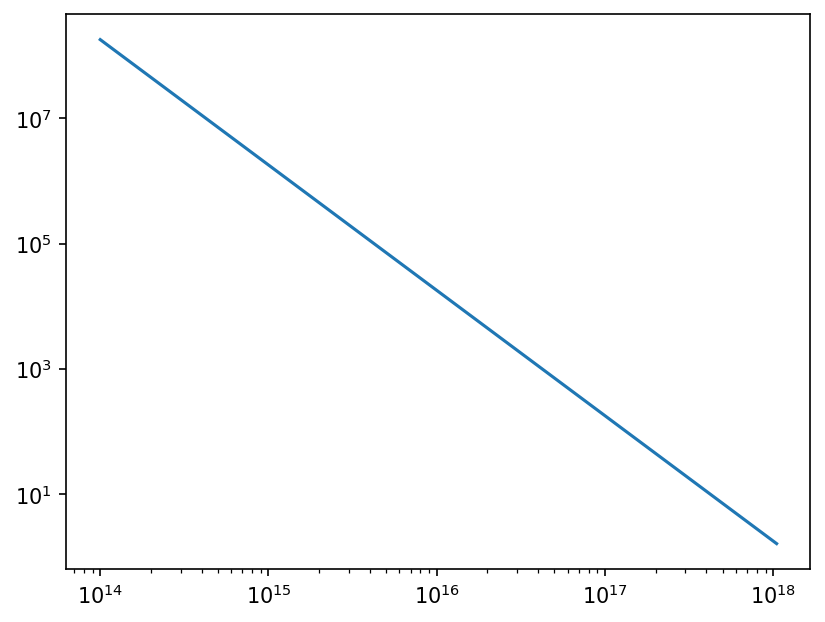

In [22]:
path = '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out'
mod = ds.CSEmod(path)

plt.loglog(mod.radius, mod.dens)

### Statistics of dataset


In [2]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 

lr = 1.e-4
epochs = 100

losstype = 'mse_idn'
# losstype = 'mse'
z_dim = 8
dt_fract = 0.2
batch_size = 1
nb_samples = 10000
n_dim = 468
nb_hidden = 1
ae_type = 'simple'
nb_test = 3000

print('------------------------------')
print('      # epochs:', epochs)
print(' learning rate:', lr)
print('# z dimensions:', z_dim)
print('     # samples:', nb_samples)
print('     loss type:', losstype)
print('')


train, test, data_loader, test_loader = ds.get_data(dt_fract=dt_fract,nb_samples=nb_samples,nb_test = nb_test, batch_size=batch_size, kwargs=kwargs)

------------------------------
      # epochs: 100
 learning rate: 0.0001
# z dimensions: 8
     # samples: 10000
     loss type: mse_idn

Dataset:
------------------------------
  total # of samples: 10000
#   training samples: 7000
# validation samples: 3000
               ratio: 0.3
     #  test samples: 3000


#### Mdot distribution dataset

In [40]:
mdot8 = list()
mdot7 = list()
mdot6 = list()
mdot5 = list()

for path in train.path:
    if path[56:57] == '8':
        mdot8.append(path)
    elif path[56:57] == '7':
        mdot7.append(path)
    elif path[56:57] == '6':
        mdot6.append(path)
    elif path[56:57] == '5':
        mdot5.append(path)

print(len(mdot8), len(mdot7), len(mdot6), len(mdot5))

1762 2112 1933 1193


In [35]:
mdot1_8 = list()
mdot2_8 = list()
mdot5_8 = list()

mdot1_7 = list()
mdot2_7 = list()
mdot5_7 = list()

mdot1_6 = list()
mdot2_6 = list()
mdot5_6 = list()

mdot1_5 = list()
mdot2_5 = list()
mdot5_5 = list()

for path in train.path:
    if path[53:57] == '1e-8':
        mdot1_8.append(path)
    elif path[53:57] == '2e-8':
        mdot2_8.append(path)
    elif path[53:57] == '5e-8':
        mdot5_8.append(path)
    elif path[53:57] == '1e-7':
        mdot1_7.append(path)
    elif path[53:57] == '2e-7':
        mdot2_7.append(path)
    elif path[53:57] == '5e-7':
        mdot5_7.append(path)
    elif path[53:57] == '1e-6':
        mdot1_6.append(path)
    elif path[53:57] == '2e-6':
        mdot2_6.append(path)
    elif path[53:57] == '5e-6':
        mdot5_6.append(path)
    elif path[53:57] == '1e-5':
        mdot1_5.append(path)
    elif path[53:57] == '2e-5':
        mdot2_5.append(path)
    elif path[53:57] == '5e-5':
        mdot5_5.append(path)

train_stats = [len(mdot1_8), len(mdot2_8), len(mdot5_8), len(mdot1_7), len(mdot2_7), len(mdot5_7), len(mdot1_6), len(mdot2_6), len(mdot5_6), len(mdot1_5), len(mdot2_5), len(mdot5_5)]


In [44]:
mdot1_8 = list()
mdot2_8 = list()
mdot5_8 = list()

mdot1_7 = list()
mdot2_7 = list()
mdot5_7 = list()

mdot1_6 = list()
mdot2_6 = list()
mdot5_6 = list()

mdot1_5 = list()
mdot2_5 = list()
mdot5_5 = list()

for path in train.testpath:
    if path[53:57] == '1e-8':
        mdot1_8.append(path)
    elif path[53:57] == '2e-8':
        mdot2_8.append(path)
    elif path[53:57] == '5e-8':
        mdot5_8.append(path)
    elif path[53:57] == '1e-7':
        mdot1_7.append(path)
    elif path[53:57] == '2e-7':
        mdot2_7.append(path)
    elif path[53:57] == '5e-7':
        mdot5_7.append(path)
    elif path[53:57] == '1e-6':
        mdot1_6.append(path)
    elif path[53:57] == '2e-6':
        mdot2_6.append(path)
    elif path[53:57] == '5e-6':
        mdot5_6.append(path)
    elif path[53:57] == '1e-5':
        mdot1_5.append(path)
    elif path[53:57] == '2e-5':
        mdot2_5.append(path)
    elif path[53:57] == '5e-5':
        mdot5_5.append(path)

test_stats = [len(mdot1_8), len(mdot2_8), len(mdot5_8), len(mdot1_7), len(mdot2_7), len(mdot5_7), len(mdot1_6), len(mdot2_6), len(mdot5_6), len(mdot1_5), len(mdot2_5), len(mdot5_5)]


In [36]:
mdot1_8 = list()
mdot2_8 = list()
mdot5_8 = list()

mdot1_7 = list()
mdot2_7 = list()
mdot5_7 = list()

mdot1_6 = list()
mdot2_6 = list()
mdot5_6 = list()

mdot1_5 = list()
mdot2_5 = list()
mdot5_5 = list()

for path in test.path:
    if path[53:57] == '1e-8':
        mdot1_8.append(path)
    elif path[53:57] == '2e-8':
        mdot2_8.append(path)
    elif path[53:57] == '5e-8':
        mdot5_8.append(path)
    elif path[53:57] == '1e-7':
        mdot1_7.append(path)
    elif path[53:57] == '2e-7':
        mdot2_7.append(path)
    elif path[53:57] == '5e-7':
        mdot5_7.append(path)
    elif path[53:57] == '1e-6':
        mdot1_6.append(path)
    elif path[53:57] == '2e-6':
        mdot2_6.append(path)
    elif path[53:57] == '5e-6':
        mdot5_6.append(path)
    elif path[53:57] == '1e-5':
        mdot1_5.append(path)
    elif path[53:57] == '2e-5':
        mdot2_5.append(path)
    elif path[53:57] == '5e-5':
        mdot5_5.append(path)

vald_stats = [len(mdot1_8), len(mdot2_8), len(mdot5_8), len(mdot1_7), len(mdot2_7), len(mdot5_7), len(mdot1_6), len(mdot2_6), len(mdot5_6), len(mdot1_5), len(mdot2_5), len(mdot5_5)]


In [37]:
loc = '/STER/silkem/MACE/'
paths = np.loadtxt(loc+'data/paths_data_C.txt', dtype=str)


mdot1_8 = list()
mdot2_8 = list()
mdot5_8 = list()

mdot1_7 = list()
mdot2_7 = list()
mdot5_7 = list()

mdot1_6 = list()
mdot2_6 = list()
mdot5_6 = list()

mdot1_5 = list()
mdot2_5 = list()
mdot5_5 = list()

print(len(paths))

for path in paths:
    if path[53:57] == '1e-8':
        mdot1_8.append(path)
    elif path[53:57] == '2e-8':
        mdot2_8.append(path)
    elif path[53:57] == '5e-8':
        mdot5_8.append(path)
    elif path[53:57] == '1e-7':
        mdot1_7.append(path)
    elif path[53:57] == '2e-7':
        mdot2_7.append(path)
    elif path[53:57] == '5e-7':
        mdot5_7.append(path)
    elif path[53:57] == '1e-6':
        mdot1_6.append(path)
    elif path[53:57] == '2e-6':
        mdot2_6.append(path)
    elif path[53:57] == '5e-6':
        mdot5_6.append(path)
    elif path[53:57] == '1e-5':
        mdot1_5.append(path)
    elif path[53:57] == '2e-5':
        mdot2_5.append(path)
    elif path[53:57] == '5e-5':
        mdot5_5.append(path)


tot_stats = [len(mdot1_8), len(mdot2_8), len(mdot5_8), len(mdot1_7), len(mdot2_7), len(mdot5_7), len(mdot1_6), len(mdot2_6), len(mdot5_6), len(mdot1_5), len(mdot2_5), len(mdot5_5)]


17998


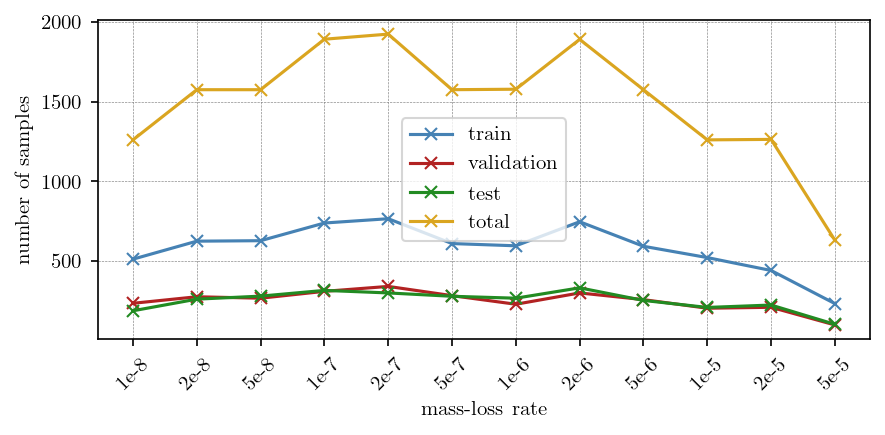

In [117]:
mdot = ['1e-8', '2e-8', '5e-8', '1e-7', '2e-7', '5e-7', '1e-6', '2e-6', '5e-6', '1e-5', '2e-5', '5e-5']

fig, ax1 = plt.subplots(1,1, figsize = (6,3))

# ax1.set_title('full dataset (18 000 samples)')

ax1.plot(train_stats, 'x-', color = 'steelblue', label = 'train')
ax1.plot(vald_stats, 'x-', color = 'firebrick', label = 'validation')
ax1.plot(test_stats, 'x-', color = 'forestgreen', label = 'test')
ax1.plot(tot_stats, 'x-', color = 'goldenrod', label = 'total')

ax1.set_xticks(np.arange(0,12,1))
ax1.set_xticklabels(mdot, rotation = 45)
ax1.set_ylabel('number of samples')
ax1.set_xlabel('mass-loss rate')

# ax1.set_yscale('log')


ax1.legend()

ax1.grid(True, linestyle='--', linewidth=0.3, color='gray')
plt.tight_layout()

plt.savefig('figs/distr_Mdot.png')

#### v distribution dataset

In [52]:
train.path[0][59:61]

'10'

In [58]:
v2 = list()
v5 = list()
v7 = list()

v10 = list()
v12 = list()
v15 = list()
v17 = list()

v20 = list()
v22 = list()
v25 = list()

rest = list()


for path in train.path:
    if path[59:61] == '2-' or path[59:61] == '2.':
        v2.append(path)
    elif path[59:61] == '5_':
        v5.append(path)
    elif path[59:61] == '7-' or path[59:61] == '7.':
        v7.append(path)
    elif path[59:61] == '10':
        v10.append(path)
    elif path[59:61] == '12':
        v12.append(path)
    elif path[59:61] == '15':
        v15.append(path)
    elif path[59:61] == '17':
        v17.append(path)
    elif path[59:61] == '20':
        v20.append(path)
    elif path[59:61] == '22':
        v22.append(path)
    elif path[59:61] == '25':
        v25.append(path)
    else:
        rest.append(path[59:61])

train_v = [len(v2), len(v5), len(v7), len(v10), len(v12), len(v15), len(v17), len(v20), len(v22), len(v25)]
sum = len(v2)+len(v5)+len(v7)+len(v10)+len(v12)+len(v15)+len(v17)+len(v20)+len(v22)+len(v25)


7000
[]


In [59]:
v2 = list()
v5 = list()
v7 = list()

v10 = list()
v12 = list()
v15 = list()
v17 = list()

v20 = list()
v22 = list()
v25 = list()

rest = list()


for path in test.path:
    if path[59:61] == '2-' or path[59:61] == '2.':
        v2.append(path)
    elif path[59:61] == '5_':
        v5.append(path)
    elif path[59:61] == '7-' or path[59:61] == '7.':
        v7.append(path)
    elif path[59:61] == '10':
        v10.append(path)
    elif path[59:61] == '12':
        v12.append(path)
    elif path[59:61] == '15':
        v15.append(path)
    elif path[59:61] == '17':
        v17.append(path)
    elif path[59:61] == '20':
        v20.append(path)
    elif path[59:61] == '22':
        v22.append(path)
    elif path[59:61] == '25':
        v25.append(path)
    else:
        rest.append(path[59:61])

vald_v = [len(v2), len(v5), len(v7), len(v10), len(v12), len(v15), len(v17), len(v20), len(v22), len(v25)]
sum = len(v2)+len(v5)+len(v7)+len(v10)+len(v12)+len(v15)+len(v17)+len(v20)+len(v22)+len(v25)


In [61]:
v2 = list()
v5 = list()
v7 = list()

v10 = list()
v12 = list()
v15 = list()
v17 = list()

v20 = list()
v22 = list()
v25 = list()

rest = list()


for path in paths:
    if path[59:61] == '2-' or path[59:61] == '2.':
        v2.append(path)
    elif path[59:61] == '5_':
        v5.append(path)
    elif path[59:61] == '7-' or path[59:61] == '7.':
        v7.append(path)
    elif path[59:61] == '10':
        v10.append(path)
    elif path[59:61] == '12':
        v12.append(path)
    elif path[59:61] == '15':
        v15.append(path)
    elif path[59:61] == '17':
        v17.append(path)
    elif path[59:61] == '20':
        v20.append(path)
    elif path[59:61] == '22':
        v22.append(path)
    elif path[59:61] == '25':
        v25.append(path)
    else:
        rest.append(path[59:61])

tot_v = [len(v2), len(v5), len(v7), len(v10), len(v12), len(v15), len(v17), len(v20), len(v22), len(v25)]
sum = len(v2)+len(v5)+len(v7)+len(v10)+len(v12)+len(v15)+len(v17)+len(v20)+len(v22)+len(v25)


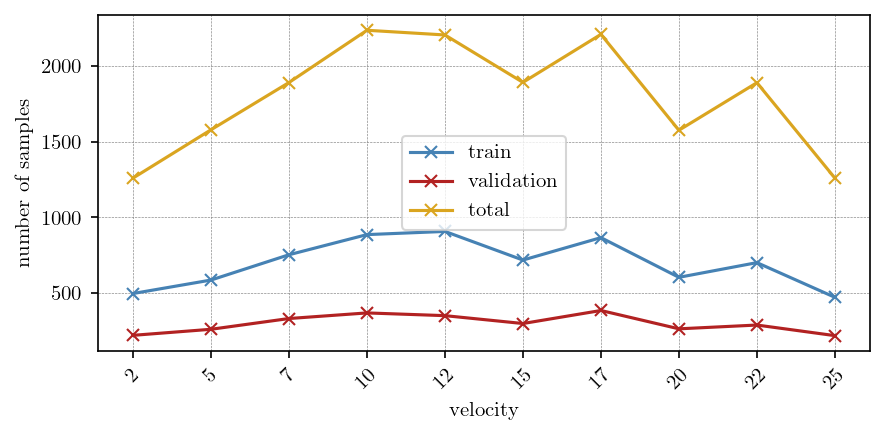

In [118]:
v = ['2', '5', '7', '10', '12', '15', '17', '20', '22', '25']

fig, ax1 = plt.subplots(1,1, figsize = (6,3))

# ax1.set_title('full dataset (18 000 samples)')

ax1.plot(train_v, 'x-', color = 'steelblue', label = 'train')
ax1.plot(vald_v, 'x-', color = 'firebrick', label = 'validation')
# ax1.plot(test_stats, 'x-', color = 'forestgreen', label = 'test')
ax1.plot(tot_v, 'x-', color = 'goldenrod', label = 'total')

ax1.set_xticks(np.arange(0,10,1))
ax1.set_xticklabels(v, rotation = 45)
ax1.set_ylabel('number of samples')
ax1.set_xlabel('velocity')

# ax1.set_yscale('log')


ax1.legend()

ax1.grid(True, linestyle='--', linewidth=0.3, color='gray')
plt.tight_layout()
plt.savefig('figs/distr_vexp.png')

#### Mdot, v -distribution

In [85]:
import astropy                  as apy
from astropy.constants import M_sun
from astropy import constants   as cst
## units & constants
Msun = M_sun.cgs.value      # gram
yr   = 31536000             # s
Msunyr = Msun/yr            # gram/s
cms  = 1e5

def density(Mdot,v,r):
    '''
    Input 
        - mass-loss rate (Mdot) in units of Msol/yr
        - outflow velocity (v) in units of km/s
        - radius (r): location of the outflow, inputs of cm
    Output
        - number density in units of cm^-3
    '''
    mu = 2.0 + 4.0*0.17
    mH = cst.u.to('g').value
    # r = 1e14 #* unt.cgs.cm                       # cm

    # r    = 1e18 #* unt.cgs.cm                       # cm
    # print(Mdot, Msunyr)
    Mdot = Mdot * Msunyr                            # gram/s
    vexp = v    * cms                               # cm/s

    dens = Mdot / (4*np.pi * vexp * r**2 * mu * mH)       # cm^-3

    # dens = dens * g_to_kg * cm_to_m**(-3)           # kg/m^3

    return dens

In [105]:

Mdot = ['1e-8' , '2e-8' , '5e-8' , '1e-7' , '2e-7' , '5e-7' , '1e-6' , '2e-6' , '5e-6' , '1e-5' , '2e-5' , '5e-5']
v    = ['2-'   , '5_'   , '7-'   , '10'   , '12'  , '15'  , '17'  , '20'  , '22'  , '25']
v2    = ['2-'   , '5_'   , '7.'   , '10'   , '12'  , '15'  , '17'  , '20'  , '22'  , '25']

Mdot_val = [1.e-8 , 2.e-8 , 5.e-8 , 1.e-7 , 2.e-7 , 5.e-7 , 1.e-6 , 2.e-6 , 5.e-6 , 1.e-5 , 2.e-5 , 5.e-5]
v_val    = [2.5   , 5.0   , 7.5   , 10.   , 12.5  , 15.0  , 17.5  , 20.0  , 22.5  , 25.0]


count = np.zeros((12,10))
dens = list()

for path in paths:

    j = path[53:57]
    i = path[59:61]

    if  (  (j == '2e-7' and i == '12') 
        or (j == '5e-6' and i == '20')
        or (j == '1e-5' and i == '20')  
        or (j == '2e-5' and i == '22') 
        or (j == '5e-7' and i == '12')  
        or (j == '2e-8' and i == '5_')    
        or (j == '1e-6' and i == '10')   
        or (j == '1e-6' and i == '12')
        or (j == '1e-7' and i == '5_')    
        or (j == '1e-7' and i == '12')
        or (j == '1e-8' and i == '5_')    
        or (j == '1e-8' and i == '10')   
        or (j == '2e-6' and i == '12') 
        or (j == '2e-7' and i == '5_')      
        or (j == '2e-7' and i == '10')
        or (j == '2e-8' and i == '2-') 
        or (j == '2e-8' and i == '10')  
        or (j == '2e-8' and i == '12') 
        or (j == '5e-7' and i == '10')   
        or (j == '5e-8' and i == '2-')  
        or (j == '5e-8' and i == '5_')    
        or (j == '5e-8' and i == '10')
        or (j == '1e-5' and i == '17') 
        or (j == '1e-6' and i == '17') 
        or (j == '2e-7' and i == '17')
        or (j == '2e-6' and i == '20')   
        or (j == '1e-6' and i == '20')   
        or (j == '5e-6' and i == '17')
        or (j == '5e-7' and i == '17') 
        or (j == '1e-5' and i == '22') 
        or (j == '2e-5' and i == '25')
        or (j == '2e-6' and i == '22') 
        or (j == '5e-6' and i == '22') 
        or (j == '5e-6' and i == '25')
        or (j == '5e-5' and i == '22') 
        or (j == '2e-7' and i == '10')   
        or (j == '5e-8' and i == '12')
        or (j == '1e-7' and i == '2-')  
        or (j == '2e-5' and i == '20')   
        or (j == '2e-5' and i == '17')
        or (j == '1e-5' and i == '25') 
        or (j == '1e-8' and i == '2-') 
        or (j == '5e-5' and i == '25') 
        or (j == '1e-7' and i == '10')  
        or (j == '2e-6' and i == '17') 
        or (j == '1e-8' and i == '7.') or (j == '1e-8' and i == '7-') 
        or (j == '2e-8' and i == '7.') or (j == '2e-8' and i == '7-') 
        or (j == '5e-8' and i == '7.') or (j == '5e-8' and i == '7-') 
        or (j == '1e-7' and i == '7.') or (j == '1e-7' and i == '7-')
        or (j == '2e-7' and i == '7.') or (j == '2e-7' and i == '7-')
        or (j == '5e-7' and i == '7.') or (j == '5e-7' and i == '7-')
        or (j == '1e-7' and i == '15') 
        or (j == '2e-7' and i == '15') 
        or (j == '5e-7' and i == '15') 
        or (j == '1e-6' and i == '15') 
        or (j == '2e-6' and i == '15') 
        or (j == '5e-6' and i == '15')     ):
            
            if i[-1] != '.':
                idx_mdot = Mdot.index(j)
                idx_v    = v.index(i)
                count[idx_mdot,idx_v] += 1 


                mdot = Mdot_val[idx_mdot]
                vel    = v_val[idx_v]
                dens.append(np.log10(density(mdot,vel,1e16)))
            else:
                idx_mdot = Mdot.index(j)
                idx_v    = v2.index(i)
                count[idx_mdot,idx_v] += 1 


                mdot = Mdot_val[idx_mdot]
                vel    = v_val[idx_v]
                dens.append(np.log10(density(mdot,vel,1e16)))

count = np.flip(count, axis=0)





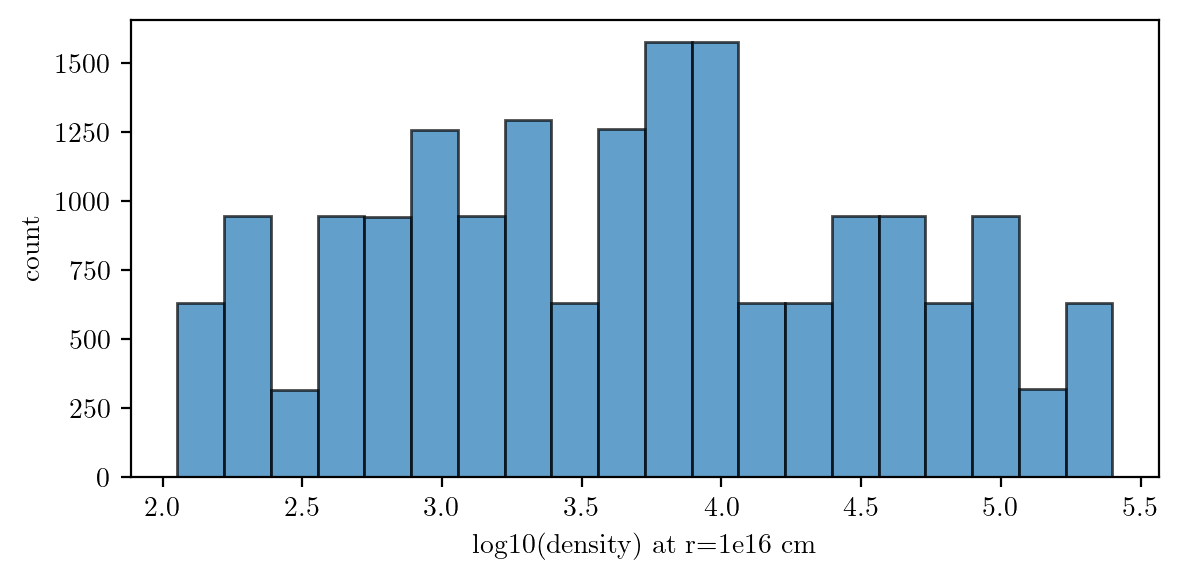

In [179]:
fig, ax1 = plt.subplots(1,1, figsize = (6,3))

ax1.hist(dens, bins = 20, edgecolor = 'black', alpha = 0.7)

ax1.set_ylabel('count')
ax1.set_xlabel('log10(density) at r=1e16 cm')


plt.tight_layout()
plt.savefig('figs/density_hist.png')


plt.show()

/tmp/ipykernel_93780/2099447267.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('GnBu')


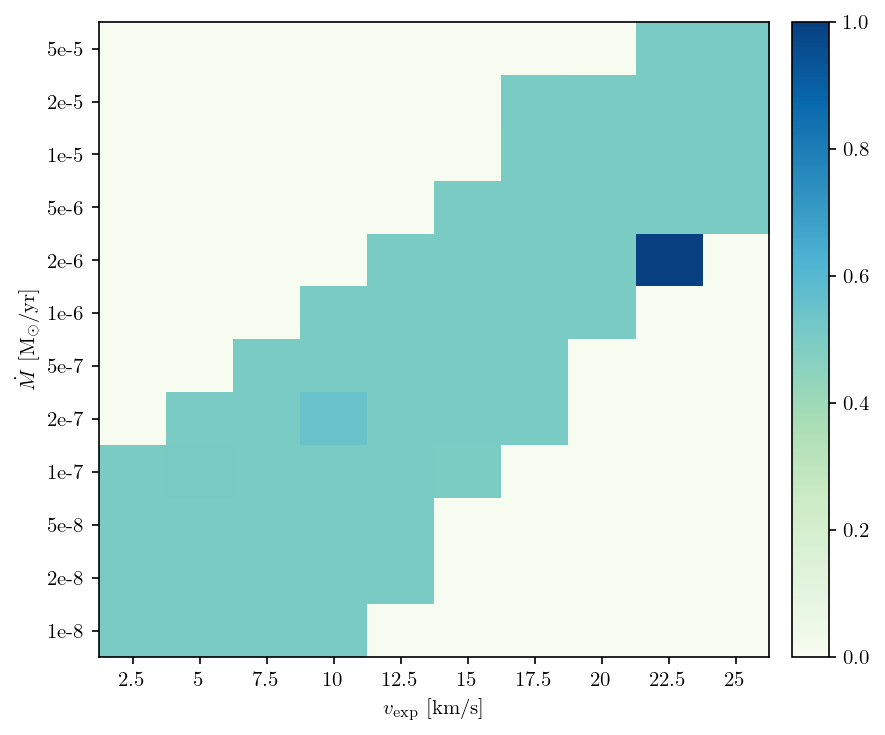

In [120]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1,2, gridspec_kw={'width_ratios': [18,1]},figsize=(6, 5))
ax1 = axs[0]

cbax = axs[1]
cmap = cm.get_cmap('GnBu')
cb = fig.colorbar(mpl.cm.ScalarMappable( cmap=cmap), cax=cbax, orientation='vertical')

ax1.imshow(count, cmap=cmap, aspect='auto', interpolation='none')



ax1.xaxis.set_major_locator(FixedLocator([0, 1,2,3,4,5,6,7,8,9]))
ax1.yaxis.set_major_locator(FixedLocator([0,1,2,3,4,5,6,7,8,9,10,11]))
ax1.set_xticklabels([ '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20', '22.5', '25'])
arr = ['1e-8', '2e-8', '5e-8', '1e-7', '2e-7', '5e-7', '1e-6', '2e-6', '5e-6', '1e-5', '2e-5', '5e-5']
ax1.set_yticklabels(arr[::-1])
ax1.set_xlabel('$v_{\\rm exp}$ [km/s]')
ax1.set_ylabel('$\\dot{M}\ {\\rm[M_{\\odot}/yr]}$')


plt.tight_layout()
plt.savefig('figs/density_count_Mdot_v.png')

plt.show()